In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import nltk
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews
import random

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


In [3]:
type(movie_reviews)

nltk.corpus.util.LazyCorpusLoader

In [4]:
documents = [(list(movie_reviews.words(fileid)), category)
              for category in movie_reviews.categories()
              for fileid in movie_reviews.fileids(category)]

random.shuffle(documents)

In [5]:
type(documents)

list

In [6]:
len(documents)

2000

In [7]:
len(documents[0])

2

In [8]:
documents[0][1]

'neg'

In [9]:
movie_reviews.categories()

['neg', 'pos']

In [10]:
# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer, WordNetLemmatizer

# Word2vec
import gensim

# SpaCy
from spacy.lang.en import English
import spacy

# Utility
import re
import numpy as np
import pandas as pd
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import pprint

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [11]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
TEXT_CLEANING_RE_NO_LINKS = "@\S+|https?:\S+|http?:\S"

In [12]:
path = "/content/drive/MyDrive/Masters/VTech Subjects/CS 5824 Advanced Machine Learning/term paper/code/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [13]:
pd.set_option('display.max_colwidth',None)

In [14]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [16]:
df.groupby(['target']).count()

,ids,date,flag,user,text
target,,,,,
0,800000,800000,800000,800000,800000
4,800000,800000,800000,800000,800000


In [17]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [18]:
sentimentMap = {0: "NEGATIVE", 4: "POSITIVE"}

def decodeSentiment(label):
  return sentimentMap[int(label)]


In [19]:
%%time
df.target = df.target.apply(lambda x: decodeSentiment(x))
display(df.head())

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


CPU times: user 608 ms, sys: 1.75 ms, total: 609 ms
Wall time: 610 ms


,ids,date,flag,user,text
target,,,,,
NEGATIVE,800000,800000,800000,800000,800000
POSITIVE,800000,800000,800000,800000,800000


Text(0.5, 1.0, 'Sentiment distribuition')

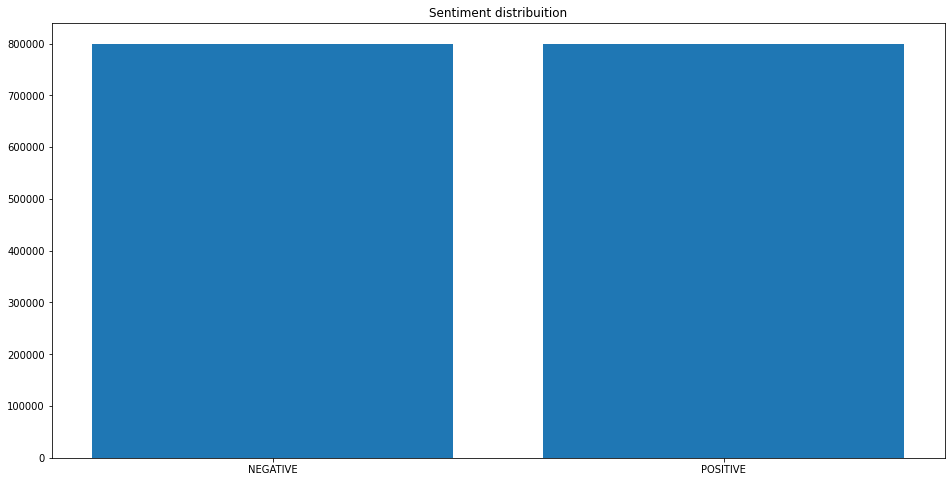

In [20]:
display(df.groupby(['target']).count())

sentimentCount = Counter(df["target"])

plt.figure(figsize=(16,8))
plt.bar(sentimentCount.keys(), sentimentCount.values())
plt.title("Sentiment distribuition")

In [21]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [22]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

In [23]:
def StemmingPreProcess(text, stem=True):
  # Remove link,user and special characters
  text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
      if token not in stop_words:
          if stem:
              tokens.append(stemmer.stem(token))
          else:
              tokens.append(token)
  return " ".join(tokens)

In [24]:
def find_emo(text):
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
  return emoticons

In [25]:
def removePunctuation(text):
  if type(text) == str:
    # text = re.sub('<[^>]*>', '', text)
    text = re.sub(TEXT_CLEANING_RE_NO_LINKS, '', text)
    text = re.sub('[\W]+', '', text.lower())
    return text

In [26]:
rowCount=0

In [27]:
# def LemmatizationPreProcess(text, nlp, tokenizer):
#   # spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
#   # spacy_stopwords is a hardcoded set

#   # for t in text:
#   #   tokens = tokenizer(str(t))
#   #   lemma_list = []
#   #   for token in tokens:
#   #     # if token.lemma_.lower() not in spacy_stopwords:
#   #     if not token.is_stop:
#   #       # lemma_list.append(token.lemma_)
#   #       token_preprocessed = removePunctuation(token.lemma_)
#   #       if token_preprocessed != '':
#   #         lemma_list.append(token_preprocessed)

#   # nlp = English()
#   # tokenizer = nlp.Defaults.create_tokenizer(nlp)

#   tokens = tokenizer(text)
#   # print(f"text: {str(text)}")
#   # tokens = tokenizer(str(text))
#   lemma_list = []
#   for token in tokens:
#     # if token.lemma_.lower() not in spacy_stopwords:
#     if not token.is_stop:
#       # lemma_list.append(token.lemma_)
#       token_preprocessed = removePunctuation(token.lemma_)
#       if token_preprocessed != '':
#         lemma_list.append(token_preprocessed)


#   # rowCount += 1
#   # print(f"rowCount: {rowCount}")
#   print(f"lemma list: {lemma_list}")
#   return " ".join(lemma_list)

In [28]:
def LemmatizationPreProcess(text, nlp, tokenizer):
  # doc = nlp(text)
  # lemma_list = [str(tok.lemma_).lower() for tok in text
  #               if not tok.is_stop]

  lemma_list = []
  for tok in text:
    if not tok.is_stop:
      token_preprocessed = removePunctuation(str(tok.lemma_))
      if token_preprocessed != '':
        lemma_list.append(token_preprocessed)

  print(f"lemma list: {lemma_list}")
  # return lemma_list
  return " ".join(lemma_list)

In [29]:
def preProcess(text, method, methodParam=True, nlp=None, tokenizer=None, rowCount=None):
  if method == "stem":
    return StemmingPreProcess(text, stem=methodParam)
  elif method == "lemma":
    # if rowCount is not None:
    #   rowCount += 1
    #   print(rowCount)

    preproc_pipe = []
    for doc in nlp.pipe(text, batch_size=1000):
        preproc_pipe.append(LemmatizationPreProcess(doc, nlp, tokenizer))
    return preproc_pipe

    # return LemmatizationPreProcess(text, nlp, tokenizer)

In [30]:
# def preProcess(text, stem=False):
#     # Remove link,user and special characters
#     text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
#     tokens = []
#     for token in text.split():
#         if token not in stop_words:
#             if stem:
#                 tokens.append(stemmer.stem(token))
#             else:
#                 tokens.append(token)
#     return " ".join(tokens)

In [ ]:
%%time
dfNoStem = df.copy()
# display(dfNoStem.head())
dfNoStem.text = dfNoStem.text.apply(lambda x: preProcess(x, method="stem", methodParam=False))
# dfNoStem.text = dfNoStem.text.apply(lambda x: StemmingPreProcess(x, stem=False))
# dfNoStem.text = dfNoStem.text.apply(lambda x: preProcess(x, stem=False))
display(dfNoStem.head())

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result school today also blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go bounds
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see


CPU times: user 1min 1s, sys: 258 ms, total: 1min 1s
Wall time: 1min 1s


In [ ]:
%%time
dfStem = df.copy()
dfStem.text = dfStem.text.apply(lambda x: preProcess(x, method="stem", methodParam=True))
display(dfStem.head())

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset updat facebook text might cri result school today also blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dive mani time ball manag save 50 rest go bound
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole bodi feel itchi like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behav mad see


CPU times: user 3min 55s, sys: 719 ms, total: 3min 56s
Wall time: 3min 57s


In [ ]:
%%time
# rowCount=0
dfLemma = df.copy()

nlp = English()
# tokenizer = nlp.Defaults.create_tokenizer(nlp)

# dfLemma.text = dfLemma.text.apply(lambda x: preProcess(x, method="lemma", nlp, tokenizer))
# dfLemma.text = dfLemma.text.apply(lambda x: preProcess(x, method="lemma", nlp=nlp, tokenizer=tokenizer))

# lemma_text_series = pd.Series()
# for text in tokenizer.pipe(dfLemma.text):

# for text in dfLemma.text:
#   print(f"text: {text}")
#   print(type(text))
#   lemma_text_series.append(preProcess(text, method="lemma", nlp=nlp, tokenizer=tokenizer))
#   print(f"Len: {lemma_text_series.shape}")
# dfLemma["lemma_text"] = lemma_text_series

# dfLemma['lemma_text'] = preProcess(dfLemma['text'], method="lemma", nlp=nlp, tokenizer=tokenizer)
dfLemma['lemma_text'] = preProcess(dfLemma['text'], method="lemma", nlp=nlp)

display(dfLemma.head())

Streaming output truncated to the last 5000 lines.
lemma list: ['whinlatter', 'tonight', 'forests', 'amp', 'zipping']
lemma list: ['touch', 'pushing', 'updates', 'regularly']
lemma list: ['bariatric', 'fusion', 'taste', 'text', 'list', 'bc', 'way']
lemma list: ['thank']
lemma list: ['bb', 'tell']
lemma list: ['hey', 's', 'yeah', 'weekend', 'went', 'arse', 'lol', 'raining', 's', 'ya']
lemma list: ['erin', 'darling', 'found', 'twitter']
lemma list: ['chapter', 'lt3']
lemma list: ['not', 'great', '2', 'kno', 'god', '4', 'know', 'weapon', 'formed', 'shall', 'prosper']
lemma list: ['ant', 'learned', 'travel', 'twitter', 'posts']
lemma list: ['cheers', 'darl']
lemma list: ['thanks', 'chris', 'good', 'wagamama', 'takes', 'customer', 'service', 'satisfaction', 'seriously', 'nice']
lemma list: ['correct', 'comments']
lemma list: ['miss', 'amp', 'love']
lemma list: ['go', 'to', 'hectic', 'days', 'taking', 'today', 'chill', 'go', 'to', 'great']
lemma list: ['sure', 'probably', '12', 'step', 'grou

,target,ids,date,flag,user,text,lemma_text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",awww bummer shoulda got david carr day d
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,upset update facebook texting cry result school today blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,dived times ball managed save 50 rest bounds
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",behaving mad


CPU times: user 16min 10s, sys: 1min 44s, total: 17min 55s
Wall time: 16min 26s


In [ ]:
df.head()

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [ ]:
dfStem.head()

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset updat facebook text might cri result school today also blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dive mani time ball manag save 50 rest go bound
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole bodi feel itchi like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behav mad see


In [ ]:
dfLemma.head()

,target,ids,date,flag,user,text,lemma_text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",awww bummer shoulda got david carr day d
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,upset update facebook texting cry result school today blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,dived times ball managed save 50 rest bounds
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",behaving mad


In [ ]:
df = dfLemma.copy()
df["stem_text"] = dfStem["text"]
df.head()

,target,ids,date,flag,user,text,lemma_text,stem_text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",awww bummer shoulda got david carr day d,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,upset update facebook texting cry result school today blah,upset updat facebook text might cri result school today also blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,dived times ball managed save 50 rest bounds,dive mani time ball manag save 50 rest go bound
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,body feels itchy like fire,whole bodi feel itchi like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",behaving mad,behav mad see


In [ ]:
df.to_csv("/content/drive/MyDrive/Masters/VTech Subjects/CS 5824 Advanced Machine Learning/term paper/code/tweets_stem_lemma.csv")

In [ ]:
# df.to_excel("/content/drive/MyDrive/Masters/VTech Subjects/CS 5824 Advanced Machine Learning/term paper/code/tweets_stem_lemma.xlsx")

In [ ]:
# df = dfStem.copy()

In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [ ]:
df_train.head()

,target,ids,date,flag,user,text,lemma_text,stem_text
583570,NEGATIVE,2214987316,Wed Jun 17 17:30:50 PDT 2009,NO_QUERY,_Mom_23,We r putting together &quot;big boy&quot; bed for 2yo-a Step 2 captains bed w/space underneath for storage or kids to crawl in &amp; play-byebye crib,r putting quotbig boyquot bed 2yo step 2 captains bed w space underneath storage kids crawl amp play byebye crib,r put togeth quot big boy quot bed 2yo step 2 captain bed w space underneath storag kid crawl amp play byeby crib
393384,NEGATIVE,2055385444,Sat Jun 06 09:13:11 PDT 2009,NO_QUERY,Carinlovesyou,wants to talk to someone,wants talk,want talk someon
1223125,POSITIVE,1990374230,Mon Jun 01 04:41:39 PDT 2009,NO_QUERY,fair_carlien,Dinner at grandma's house,dinner grandma house,dinner grandma hous
1054876,POSITIVE,1962095809,Fri May 29 10:30:59 PDT 2009,NO_QUERY,alexiskn,"@TheNoLookPass awww thanks!! (also, I miss - and seriously heart - Dirk.)",awww thanks miss seriously heart dirk,awww thank also miss serious heart dirk
776737,NEGATIVE,2322231679,Wed Jun 24 22:15:49 PDT 2009,NO_QUERY,MarinaIvory,@Mayysian well both Ateh and i called &amp; text u. U got us worried.,ateh called amp text u u got worried,well ateh call amp text u u got us worri


In [ ]:
df_test.head()

,target,ids,date,flag,user,text,lemma_text,stem_text
908575,POSITIVE,1750896036,Sat May 09 18:10:44 PDT 2009,NO_QUERY,HiddenEloise,i'm about to munch on some more high calorie things! they keep my brain working,munch high calorie things brain working,munch high calori thing keep brain work
1386360,POSITIVE,2052831816,Sat Jun 06 02:11:41 PDT 2009,NO_QUERY,SkylieWilde,lifes complete. all time low were a-fucking-mazing,lifes complete time low fucking mazing,life complet time low fuck maze
246878,NEGATIVE,1982346116,Sun May 31 11:01:31 PDT 2009,NO_QUERY,Dillworth84,"Prossecco too acidic for me. I find they lack body, not that I'd know",prossecco acidic find lack body know,prossecco acid find lack bodi know
1116262,POSITIVE,1973105285,Sat May 30 10:29:48 PDT 2009,NO_QUERY,ZaphodCamden,@phil_marriott I saw it yesterday - it was hilarious,saw yesterday hilarious,saw yesterday hilari
732398,NEGATIVE,2264061329,Sun Jun 21 02:39:34 PDT 2009,NO_QUERY,capoband,"@thetoniomethod Bro, the link doesn't work....",bro link work,bro link work


In [ ]:
%%time
# documents = [_text.split() for _text in df_train.text] 
documents = [_text.split() for _text in df_train.stem_text] 

CPU times: user 3.6 s, sys: 658 ms, total: 4.26 s
Wall time: 4.26 s


In [ ]:
documents[:3]

[['r',
  'put',
  'togeth',
  'quot',
  'big',
  'boy',
  'quot',
  'bed',
  '2yo',
  'step',
  '2',
  'captain',
  'bed',
  'w',
  'space',
  'underneath',
  'storag',
  'kid',
  'crawl',
  'amp',
  'play',
  'byeby',
  'crib'],
 ['want', 'talk', 'someon'],
 ['dinner', 'grandma', 'hous']]

In [ ]:
twtWordLst = [Counter(twt) for twt in documents]

In [ ]:
pprint.pprint(twtWordLst[:3])

[Counter({'quot': 2,
          'bed': 2,
          'r': 1,
          'put': 1,
          'togeth': 1,
          'big': 1,
          'boy': 1,
          '2yo': 1,
          'step': 1,
          '2': 1,
          'captain': 1,
          'w': 1,
          'space': 1,
          'underneath': 1,
          'storag': 1,
          'kid': 1,
          'crawl': 1,
          'amp': 1,
          'play': 1,
          'byeby': 1,
          'crib': 1}),
 Counter({'want': 1, 'talk': 1, 'someon': 1}),
 Counter({'dinner': 1, 'grandma': 1, 'hous': 1})]


In [ ]:
type(df.text)

pandas.core.series.Series

In [ ]:
textLst = df.text.to_list()

In [ ]:
len(textLst)

1600000

In [ ]:
textLst[:2]

["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"]

In [ ]:
countVector = CountVectorizer()

In [ ]:
# X=countVector.fit_transform(df.text.to_list())
X=countVector.fit_transform(df.stem_text.to_list())

In [ ]:
len(countVector.get_feature_names_out())

288396

In [ ]:
countVector.get_feature_names_out()[-50:]

array(['zzkalzz', 'zzombi', 'zzomg', 'zzr', 'zzs', 'zztop', 'zzz',
       'zzzing', 'zzzonk', 'zzzs', 'zzzuu', 'zzzz', 'zzzzi', 'zzzzland',
       'zzzzness', 'zzzzs', 'zzzzz', 'zzzzzs', 'zzzzzz', 'zzzzzzs',
       'zzzzzzz', 'zzzzzzzs', 'zzzzzzzz', 'zzzzzzzzlullabi', 'zzzzzzzzz',
       'zzzzzzzzzz', 'zzzzzzzzzzs', 'zzzzzzzzzzz', 'zzzzzzzzzzzs',
       'zzzzzzzzzzzz', 'zzzzzzzzzzzzz', 'zzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzz', 'zzzzzzzzzzzzzzzz', 'zzzzzzzzzzzzzzzzs',
       'zzzzzzzzzzzzzzzzz', 'zzzzzzzzzzzzzzzzzz', 'zzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzz', 'zzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzz', 'zzzzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzz', 'zzzzzzzzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzz', 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz

In [ ]:
cvDict = countVector.vocabulary_

In [ ]:
len(cvDict)

288396

In [ ]:
type(cvDict)

dict

In [ ]:
i = 0
for k,v in cvDict.items():
  if i ==5:
    break
  i+=1
  print(k, v)



awww 26264
bummer 43905
shoulda 227126
got 104098
david 66522


In [ ]:
cvDict["00009"]

8

In [ ]:
corpus = [
'This is the first document.',
'This document is the second document.',
'And this is the third one.',
'Is this the first document?',
]

vectorizer = CountVectorizer()
XY = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()

array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third',
       'this'], dtype=object)

In [ ]:
# vectorizer = CountVectorizer()
# XY = vectorizer.fit_transform(df.text.head().to_list())
# vectorizer.get_feature_names_out()[:10]

vectorizer = CountVectorizer()
XY = vectorizer.fit_transform(df.stem_text.head().to_list())
vectorizer.get_feature_names_out()[:10]

array(['50', 'also', 'awww', 'ball', 'behav', 'blah', 'bodi', 'bound',
       'bummer', 'carr'], dtype=object)

In [ ]:
dfw = pd.DataFrame(XY.toarray(), columns=vectorizer.get_feature_names)
display(dfw.head(2))

TypeError: ignored

In [ ]:
# # Instantiate the CountVectorizer method
# count_vector = CountVectorizer()

# # Fit the training data and then return the matrix
# training_data = count_vector.fit_transform(df_train.text)

# # Transform testing data and return the matrix. 
# testing_data = count_vector.transform(df_test.text)

# Instantiate the CountVectorizer method
count_vector = CountVectorizer()

# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(df_train.stem_text)

# Transform testing data and return the matrix. 
testing_data = count_vector.transform(df_test.stem_text)

In [ ]:
print (training_data.shape)

(1280000, 248860)


In [ ]:
print (testing_data.shape)

(320000, 248860)


In [ ]:
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data,df_train.target)

MultinomialNB()

In [ ]:
#Make prediction on test dataset
predictions = naive_bayes.predict(testing_data)

In [ ]:
type(predictions)

numpy.ndarray

In [ ]:
predictions[:5]

array(['NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE'],
      dtype='<U8')

In [ ]:
df_test.target[:5]

908575     POSITIVE
1386360    POSITIVE
246878     NEGATIVE
1116262    POSITIVE
732398     NEGATIVE
Name: target, dtype: object

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: {}'.format(accuracy_score(df_test.target, predictions)))
print('Precision score: {}'.format(precision_score(df_test.target, predictions, pos_label="POSITIVE")))
print('Recall score: {}'.format(recall_score(df_test.target, predictions, pos_label="POSITIVE")))
print('F1 score: {}'.format(f1_score(df_test.target, predictions, pos_label="POSITIVE")))

Accuracy score: 0.7628625
Precision score: 0.7734160447158411
Recall score: 0.7456902728195927
F1 score: 0.7593001421031262


In [ ]:
print(classification_report(df_test.target, predictions))

              precision    recall  f1-score   support

    NEGATIVE       0.75      0.78      0.77    159491
    POSITIVE       0.77      0.75      0.76    160509

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



In [35]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

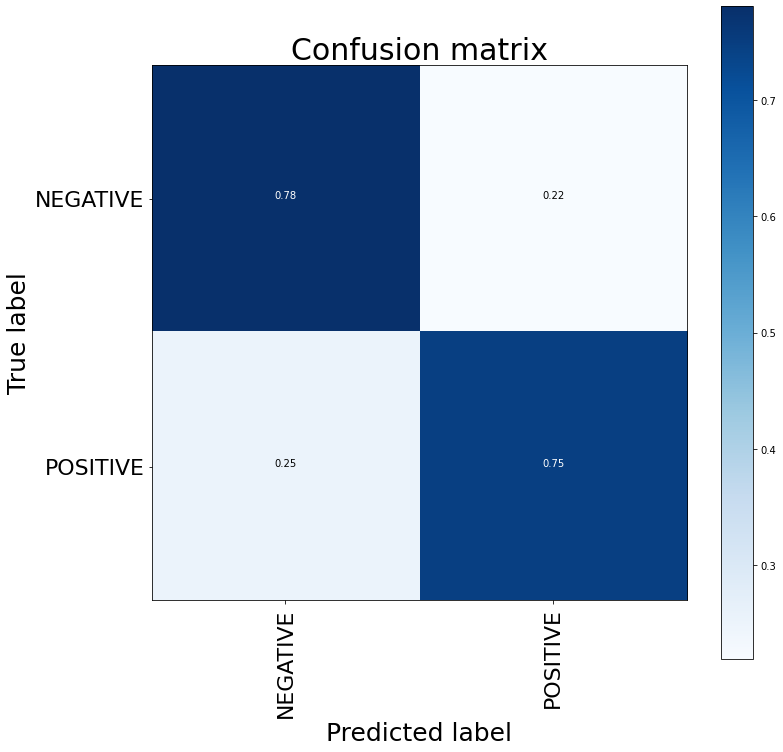

CPU times: user 2.06 s, sys: 11 ms, total: 2.07 s
Wall time: 2.09 s


In [ ]:
%%time

cnf_matrix = confusion_matrix(df_test.target, predictions)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

Now for Lemmatization Text

In [ ]:
# Instantiate the CountVectorizer method
count_vector = CountVectorizer()

# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(df_train.lemma_text)

# Transform testing data and return the matrix. 
testing_data = count_vector.transform(df_test.lemma_text)

naive_bayes = MultinomialNB()
naive_bayes.fit(training_data,df_train.target)

#Make prediction on test dataset
predictions = naive_bayes.predict(testing_data)

print(type(predictions))

print(predictions[:5])

print(df_test.target[:5])

# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: {}'.format(accuracy_score(df_test.target, predictions)))
print('Precision score: {}'.format(precision_score(df_test.target, predictions, pos_label="POSITIVE")))
print('Recall score: {}'.format(recall_score(df_test.target, predictions, pos_label="POSITIVE")))
print('F1 score: {}'.format(f1_score(df_test.target, predictions, pos_label="POSITIVE")))

print(classification_report(df_test.target, predictions))

<class 'numpy.ndarray'>
['NEGATIVE' 'POSITIVE' 'NEGATIVE' 'POSITIVE' 'NEGATIVE']
908575     POSITIVE
1386360    POSITIVE
246878     NEGATIVE
1116262    POSITIVE
732398     NEGATIVE
Name: target, dtype: object
Accuracy score: 0.765178125
Precision score: 0.7735703939188063
Recall score: 0.7519453737796634
F1 score: 0.76260461060686
              precision    recall  f1-score   support

    NEGATIVE       0.76      0.78      0.77    159491
    POSITIVE       0.77      0.75      0.76    160509

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



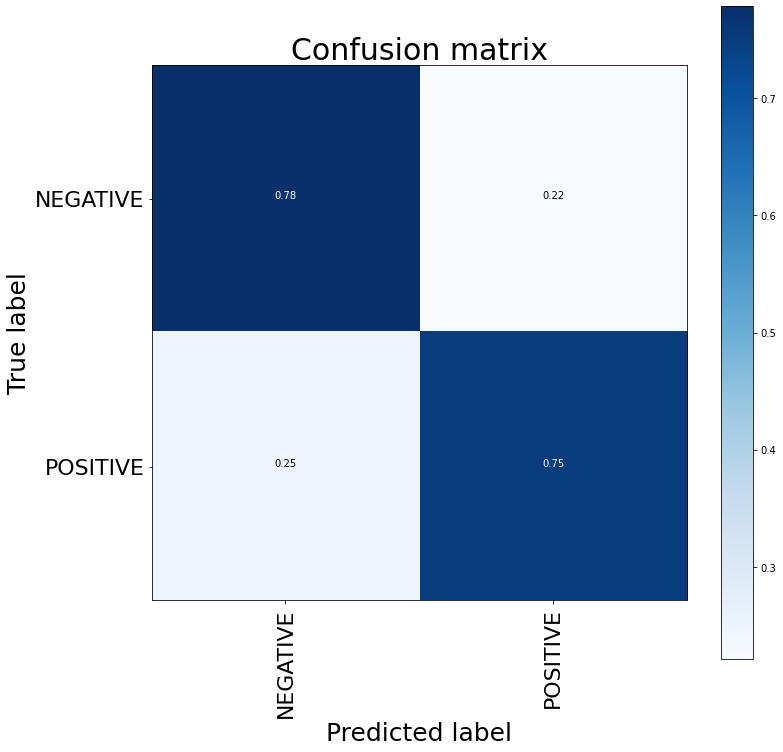

CPU times: user 2.05 s, sys: 5.93 ms, total: 2.06 s
Wall time: 2.06 s


In [ ]:
%%time

cnf_matrix = confusion_matrix(df_test.target, predictions)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

## Now for 200K smaller dataset for comparison with SVM

In [31]:
df_200_neg = df[:100000]
df_200_pos = df[-100000:]
df_200_frames = [df_200_neg, df_200_pos]
df_200 = pd.concat(df_200_frames)

In [33]:
df_200.shape

(200000, 6)

In [34]:
df_200

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
...,...,...,...,...,...,...
1599995,POSITIVE,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
1599996,POSITIVE,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599997,POSITIVE,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
1599998,POSITIVE,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


In [36]:
%%time
df_200_Stem = df_200.copy()
df_200_Stem.text = df_200_Stem.text.apply(lambda x: preProcess(x, method="stem", methodParam=True))
display(df_200_Stem)

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset updat facebook text might cri result school today also blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dive mani time ball manag save 50 rest go bound
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole bodi feel itchi like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behav mad see
...,...,...,...,...,...,...
1599995,POSITIVE,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,woke school best feel ever
1599996,POSITIVE,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,thewdb com cool hear old walt interview
1599997,POSITIVE,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,readi mojo makeov ask detail
1599998,POSITIVE,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,happi 38th birthday boo alll time tupac amaru shakur


CPU times: user 30.1 s, sys: 91.8 ms, total: 30.2 s
Wall time: 30.2 s


In [37]:
%%time
# rowCount=0
df_200_Lemma = df_200.copy()

nlp = English()
# tokenizer = nlp.Defaults.create_tokenizer(nlp)

# dfLemma.text = dfLemma.text.apply(lambda x: preProcess(x, method="lemma", nlp, tokenizer))
# dfLemma.text = dfLemma.text.apply(lambda x: preProcess(x, method="lemma", nlp=nlp, tokenizer=tokenizer))

# lemma_text_series = pd.Series()
# for text in tokenizer.pipe(dfLemma.text):

# for text in dfLemma.text:
#   print(f"text: {text}")
#   print(type(text))
#   lemma_text_series.append(preProcess(text, method="lemma", nlp=nlp, tokenizer=tokenizer))
#   print(f"Len: {lemma_text_series.shape}")
# dfLemma["lemma_text"] = lemma_text_series

# dfLemma['lemma_text'] = preProcess(dfLemma['text'], method="lemma", nlp=nlp, tokenizer=tokenizer)
df_200_Lemma['lemma_text'] = preProcess(df_200_Lemma['text'], method="lemma", nlp=nlp)

display(df_200_Lemma)

Streaming output truncated to the last 5000 lines.
lemma list: ['whinlatter', 'tonight', 'forests', 'amp', 'zipping']
lemma list: ['touch', 'pushing', 'updates', 'regularly']
lemma list: ['bariatric', 'fusion', 'taste', 'text', 'list', 'bc', 'way']
lemma list: ['thank']
lemma list: ['bb', 'tell']
lemma list: ['hey', 's', 'yeah', 'weekend', 'went', 'arse', 'lol', 'raining', 's', 'ya']
lemma list: ['erin', 'darling', 'found', 'twitter']
lemma list: ['chapter', 'lt3']
lemma list: ['not', 'great', '2', 'kno', 'god', '4', 'know', 'weapon', 'formed', 'shall', 'prosper']
lemma list: ['ant', 'learned', 'travel', 'twitter', 'posts']
lemma list: ['cheers', 'darl']
lemma list: ['thanks', 'chris', 'good', 'wagamama', 'takes', 'customer', 'service', 'satisfaction', 'seriously', 'nice']
lemma list: ['correct', 'comments']
lemma list: ['miss', 'amp', 'love']
lemma list: ['go', 'to', 'hectic', 'days', 'taking', 'today', 'chill', 'go', 'to', 'great']
lemma list: ['sure', 'probably', '12', 'step', 'grou

,target,ids,date,flag,user,text,lemma_text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",awww bummer shoulda got david carr day d
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,upset update facebook texting cry result school today blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,dived times ball managed save 50 rest bounds
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",behaving mad
...,...,...,...,...,...,...,...
1599995,POSITIVE,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever,woke having school best feeling
1599996,POSITIVE,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta,thewdbcom cool hear old walt interviews â
1599997,POSITIVE,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details,ready mojo makeover ask details
1599998,POSITIVE,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur,happy 38th birthday boo alll time tupac amaru shakur


CPU times: user 2min 1s, sys: 13.5 s, total: 2min 14s
Wall time: 2min 3s


In [38]:
df_200_stem_lem = df_200_Lemma.copy()
df_200_stem_lem["stem_text"] = df_200_Stem["text"]
df_200_stem_lem

,target,ids,date,flag,user,text,lemma_text,stem_text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",awww bummer shoulda got david carr day d,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,upset update facebook texting cry result school today blah,upset updat facebook text might cri result school today also blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,dived times ball managed save 50 rest bounds,dive mani time ball manag save 50 rest go bound
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,body feels itchy like fire,whole bodi feel itchi like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",behaving mad,behav mad see
...,...,...,...,...,...,...,...,...
1599995,POSITIVE,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever,woke having school best feeling,woke school best feel ever
1599996,POSITIVE,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta,thewdbcom cool hear old walt interviews â,thewdb com cool hear old walt interview
1599997,POSITIVE,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details,ready mojo makeover ask details,readi mojo makeov ask detail
1599998,POSITIVE,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur,happy 38th birthday boo alll time tupac amaru shakur,happi 38th birthday boo alll time tupac amaru shakur


In [39]:
df_200_stem_lem.to_csv("/content/drive/MyDrive/Masters/VTech Subjects/CS 5824 Advanced Machine Learning/term paper/code/tweets_200K_stem_lemma.csv")

In [40]:
df_200_train, df_200_test = train_test_split(df_200_stem_lem, test_size=1-TRAIN_SIZE)
print("TRAIN size 200K tweets:", len(df_200_train))
print("TEST size 200K tweets:", len(df_200_test))

TRAIN size 200K tweets: 160000
TEST size 200K tweets: 40000


In [41]:
df_200_train.head()

,target,ids,date,flag,user,text,lemma_text,stem_text
64765,NEGATIVE,1688927861,Sun May 03 12:14:05 PDT 2009,NO_QUERY,kpoythress,Another tornado on the way to pelham area. Katie is stranded.,tornado way pelham area katie stranded,anoth tornado way pelham area kati strand
99557,NEGATIVE,1793657852,Thu May 14 03:31:46 PDT 2009,NO_QUERY,The_Stuart,Why hasn't my R4 card arrived Hmph.,r4 card arrived hmph,r4 card arriv hmph
76368,NEGATIVE,1695611392,Mon May 04 06:33:03 PDT 2009,NO_QUERY,yogamachic,practicing non-attachment: thought dh put our goat's milk in the fridge only 2 b surprised 2 find them still in the cooler this am!!,practicing non attachment thought dh goat milk fridge 2 b surprised 2 find cooler,practic non attach thought dh put goat milk fridg 2 b surpris 2 find still cooler
1584542,POSITIVE,2190573673,Tue Jun 16 03:06:57 PDT 2009,NO_QUERY,raeraegrant23,had sooo much fun tonight...i love monday nights in pullman,sooo fun tonight love monday nights pullman,sooo much fun tonight love monday night pullman
1545147,POSITIVE,2182023179,Mon Jun 15 12:36:59 PDT 2009,NO_QUERY,mareeba,"After four months iPhone 3GS is it, baby. Will happen on Friday.",months iphone 3gs baby happen friday,four month iphon 3gs babi happen friday


In [42]:
df_200_test.head()

,target,ids,date,flag,user,text,lemma_text,stem_text
98456,NEGATIVE,1793305704,Thu May 14 02:10:36 PDT 2009,NO_QUERY,pandaaMONIA,@Mimza I LOVE YOU WHERE HAVE YOU BEEN. &gt;,love gt,love gt
1502029,POSITIVE,2071589815,Sun Jun 07 19:38:14 PDT 2009,NO_QUERY,wtksmmhm,@theuthguy Lol.,lol,lol
22103,NEGATIVE,1557413241,Sun Apr 19 03:58:03 PDT 2009,NO_QUERY,kesouthall,"film meet would have been great today in this weather - alas, my back has other ideas",film meet great today weather alas ideas,film meet would great today weather ala back idea
1524909,POSITIVE,2176793952,Mon Jun 15 04:46:08 PDT 2009,NO_QUERY,ivetheterrible,"Five hours worth of BodyCombat, BodyPump and Gym at the leisure centre today! What an achievement",hours worth bodycombat bodypump gym leisure centre today achievement,five hour worth bodycombat bodypump gym leisur centr today achiev
1573038,POSITIVE,2189033831,Mon Jun 15 23:05:36 PDT 2009,NO_QUERY,nesjane,going shopping for bus lollies and food for camp and plates,going shopping bus lollies food camp plates,go shop bus lolli food camp plate


In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Instantiate the CountVectorizer method
count_vector = CountVectorizer()

# Fit the training data and then return the matrix
training_200_data = count_vector.fit_transform(df_200_train.stem_text)

# Transform testing data and return the matrix. 
testing_200_data = count_vector.transform(df_200_test.stem_text)

naive_bayes = MultinomialNB()
naive_bayes.fit(training_200_data,df_200_train.target)

#Make prediction on test dataset
predictions = naive_bayes.predict(testing_200_data)

print(type(predictions))

print(predictions[:5])

print(df_200_test.target[:5])

# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: {}'.format(accuracy_score(df_200_test.target, predictions)))
print('Precision score: {}'.format(precision_score(df_200_test.target, predictions, pos_label="POSITIVE")))
print('Recall score: {}'.format(recall_score(df_200_test.target, predictions, pos_label="POSITIVE")))
print('F1 score: {}'.format(f1_score(df_200_test.target, predictions, pos_label="POSITIVE")))

print(classification_report(df_200_test.target, predictions))

<class 'numpy.ndarray'>
['POSITIVE' 'POSITIVE' 'NEGATIVE' 'NEGATIVE' 'NEGATIVE']
98456      NEGATIVE
1502029    POSITIVE
22103      NEGATIVE
1524909    POSITIVE
1573038    POSITIVE
Name: target, dtype: object
Accuracy score: 0.7585
Precision score: 0.7771574413782102
Recall score: 0.7277072442120985
F1 score: 0.7516198704103672
              precision    recall  f1-score   support

    NEGATIVE       0.74      0.79      0.77     19915
    POSITIVE       0.78      0.73      0.75     20085

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



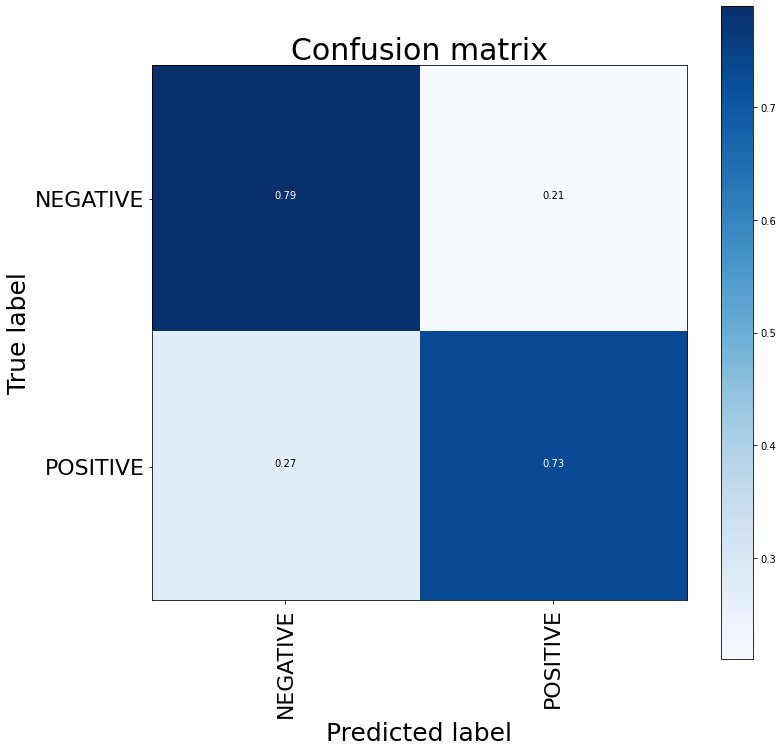

CPU times: user 466 ms, sys: 4.21 ms, total: 471 ms
Wall time: 480 ms


In [45]:
%%time

cnf_matrix = confusion_matrix(df_200_test.target, predictions)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_200_train.target.unique(), title="Confusion matrix")
plt.show()

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Instantiate the CountVectorizer method
count_vector = CountVectorizer()

# Fit the training data and then return the matrix
training_200_data = count_vector.fit_transform(df_200_train.lemma_text)

# Transform testing data and return the matrix. 
testing_200_data = count_vector.transform(df_200_test.lemma_text)

naive_bayes = MultinomialNB()
naive_bayes.fit(training_200_data,df_200_train.target)

#Make prediction on test dataset
predictions = naive_bayes.predict(testing_200_data)

print(type(predictions))

print(predictions[:5])

print(df_200_test.target[:5])

# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: {}'.format(accuracy_score(df_200_test.target, predictions)))
print('Precision score: {}'.format(precision_score(df_200_test.target, predictions, pos_label="POSITIVE")))
print('Recall score: {}'.format(recall_score(df_200_test.target, predictions, pos_label="POSITIVE")))
print('F1 score: {}'.format(f1_score(df_200_test.target, predictions, pos_label="POSITIVE")))

print(classification_report(df_200_test.target, predictions))

<class 'numpy.ndarray'>
['POSITIVE' 'POSITIVE' 'NEGATIVE' 'NEGATIVE' 'POSITIVE']
98456      NEGATIVE
1502029    POSITIVE
22103      NEGATIVE
1524909    POSITIVE
1573038    POSITIVE
Name: target, dtype: object
Accuracy score: 0.76075
Precision score: 0.7786020878596789
Recall score: 0.7315409509584266
F1 score: 0.7543382277441215
              precision    recall  f1-score   support

    NEGATIVE       0.74      0.79      0.77     19915
    POSITIVE       0.78      0.73      0.75     20085

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



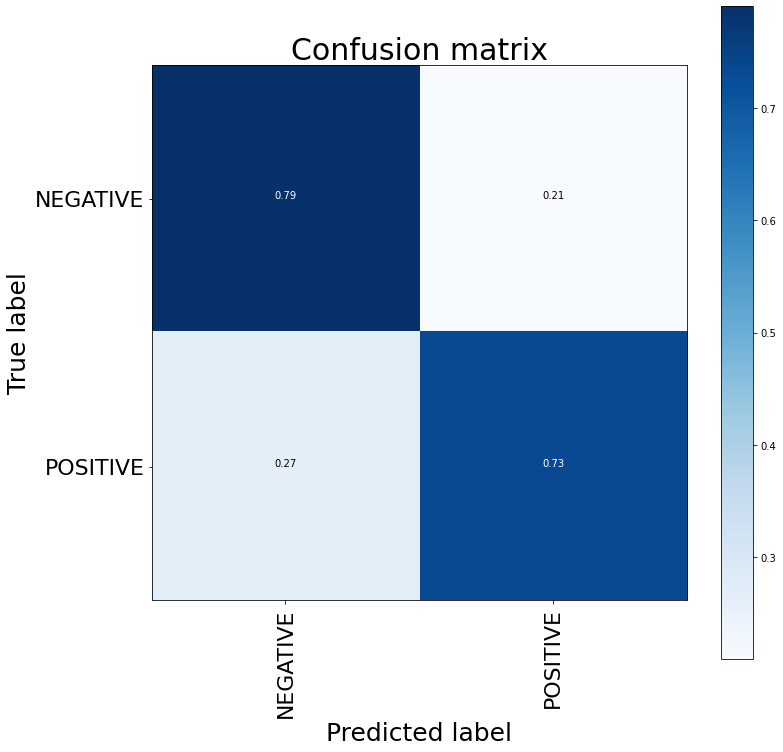

CPU times: user 466 ms, sys: 2.84 ms, total: 469 ms
Wall time: 476 ms


In [47]:
%%time

cnf_matrix = confusion_matrix(df_200_test.target, predictions)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_200_train.target.unique(), title="Confusion matrix")
plt.show()

## Trying to apply some salting

In [52]:
df_100_neg = df[100001:200001]
df_100_pos = df[-200000:-100000]
df_100_frames = [df_100_neg, df_100_pos]
df_100 = pd.concat(df_100_frames)

In [53]:
df_100_neg

,target,ids,date,flag,user,text
100001,NEGATIVE,1793821214,Thu May 14 04:06:05 PDT 2009,NO_QUERY,sumooqip,@APGB yeah. just good. Deadpool was WAAAAAY wrong
100002,NEGATIVE,1793822017,Thu May 14 04:06:14 PDT 2009,NO_QUERY,thatissodope,I feel bad for Danny Gokey.
100003,NEGATIVE,1793822122,Thu May 14 04:06:15 PDT 2009,NO_QUERY,disney_deb,How much blood do they need from...they took even more today
100004,NEGATIVE,1793822407,Thu May 14 04:06:18 PDT 2009,NO_QUERY,_magic8ball,@Sebaastgeen My reply is no
100005,NEGATIVE,1793822439,Thu May 14 04:06:19 PDT 2009,NO_QUERY,klarnie,Noooo!!!! It's raining today! And we have to walk around Arlington National Cemetary
...,...,...,...,...,...,...
199996,NEGATIVE,1971570223,Sat May 30 07:24:14 PDT 2009,NO_QUERY,gogetphilled,work... again
199997,NEGATIVE,1971570317,Sat May 30 07:24:15 PDT 2009,NO_QUERY,CocaBeenSlinky,@damienfranco Its so common for it to crash now I find I have to delete the process then its ok again for a while its eating memory
199998,NEGATIVE,1971570508,Sat May 30 07:24:16 PDT 2009,NO_QUERY,dwfavoritegirl,my baby boy is wearing big boy underwear
199999,NEGATIVE,1971570762,Sat May 30 07:24:18 PDT 2009,NO_QUERY,LuisIsLegend,Fml! I forgot my phone charger @home!


In [54]:
df_100_pos

,target,ids,date,flag,user,text
1400000,POSITIVE,2054321844,Sat Jun 06 07:05:32 PDT 2009,NO_QUERY,dogzero,"@ggerrard Hi Gareth, @Banksyart is now at @Banksyart2 - has been posting there since having probs with his @Banksyart account. Peace"
1400001,POSITIVE,2054321872,Sat Jun 06 07:05:33 PDT 2009,NO_QUERY,forbairt,@kdaly100 ouch ... when she's back to you in 3 months saying its still not working ...
1400002,POSITIVE,2054321916,Sat Jun 06 07:05:33 PDT 2009,NO_QUERY,kellobellow,"is excited for today's first day of summer vacation adventures - bridesmaid dress shopping, then road trip to hershey for the bears game!"
1400003,POSITIVE,2054322036,Sat Jun 06 07:05:34 PDT 2009,NO_QUERY,2ilyrose,"In south carolina, finally"
1400004,POSITIVE,2054322058,Sat Jun 06 07:05:34 PDT 2009,NO_QUERY,tyaloveshoes,watching manohara on extravaganza. funny. LMAO
...,...,...,...,...,...,...
1499995,POSITIVE,2071031339,Sun Jun 07 18:43:00 PDT 2009,NO_QUERY,evangenitals,Receiving the first check made out to the Evangenitals! Woot woot!
1499996,POSITIVE,2071031462,Sun Jun 07 18:43:01 PDT 2009,NO_QUERY,jasonavp,http://twitpic.com/6vluu - R.I.P Jeffrey Guy Dean. I miss my father! And my turtle haha
1499997,POSITIVE,2071031478,Sun Jun 07 18:43:01 PDT 2009,NO_QUERY,ZeJuria,@Clark427 Thanks! You're a doll for saying so
1499998,POSITIVE,2071031494,Sun Jun 07 18:43:01 PDT 2009,NO_QUERY,blooooooo,@heycassadee Can I ask a question?


In [55]:
df_100

,target,ids,date,flag,user,text
100001,NEGATIVE,1793821214,Thu May 14 04:06:05 PDT 2009,NO_QUERY,sumooqip,@APGB yeah. just good. Deadpool was WAAAAAY wrong
100002,NEGATIVE,1793822017,Thu May 14 04:06:14 PDT 2009,NO_QUERY,thatissodope,I feel bad for Danny Gokey.
100003,NEGATIVE,1793822122,Thu May 14 04:06:15 PDT 2009,NO_QUERY,disney_deb,How much blood do they need from...they took even more today
100004,NEGATIVE,1793822407,Thu May 14 04:06:18 PDT 2009,NO_QUERY,_magic8ball,@Sebaastgeen My reply is no
100005,NEGATIVE,1793822439,Thu May 14 04:06:19 PDT 2009,NO_QUERY,klarnie,Noooo!!!! It's raining today! And we have to walk around Arlington National Cemetary
...,...,...,...,...,...,...
1499995,POSITIVE,2071031339,Sun Jun 07 18:43:00 PDT 2009,NO_QUERY,evangenitals,Receiving the first check made out to the Evangenitals! Woot woot!
1499996,POSITIVE,2071031462,Sun Jun 07 18:43:01 PDT 2009,NO_QUERY,jasonavp,http://twitpic.com/6vluu - R.I.P Jeffrey Guy Dean. I miss my father! And my turtle haha
1499997,POSITIVE,2071031478,Sun Jun 07 18:43:01 PDT 2009,NO_QUERY,ZeJuria,@Clark427 Thanks! You're a doll for saying so
1499998,POSITIVE,2071031494,Sun Jun 07 18:43:01 PDT 2009,NO_QUERY,blooooooo,@heycassadee Can I ask a question?


In [59]:
df_salt_1_percent = df_100.sample(frac = 0.01)
display(df_salt_1_percent)
df_salt_3_percent = df_100.sample(frac = 0.03)
display(df_salt_3_percent)
df_salt_5_percent = df_100.sample(frac = 0.05)
display(df_salt_5_percent)

,target,ids,date,flag,user,text
1498961,POSITIVE,2070705556,Sun Jun 07 18:09:36 PDT 2009,NO_QUERY,sammywhammmy,"Watching Mr.Wonder He's just GREAT seriously, love him."
1444734,POSITIVE,2062300407,Sat Jun 06 22:51:03 PDT 2009,NO_QUERY,itsLissa,@InkBlue lol noooo way
156865,NEGATIVE,1956236893,Thu May 28 21:27:29 PDT 2009,NO_QUERY,Faithlesshope,Tomorrow is going to be a miserable day at work...
1454814,POSITIVE,2063357695,Sun Jun 07 02:20:07 PDT 2009,NO_QUERY,ManuelDorta92,Good Morning twitters Im soo Tired!
1458043,POSITIVE,2063635309,Sun Jun 07 03:28:06 PDT 2009,NO_QUERY,BonesNeko_UK,"Hmmm...wonder what @AgentSullivan and @SpcAgentPerotta are up to, they've both been offline for a long time!"
...,...,...,...,...,...,...
161850,NEGATIVE,1957412353,Fri May 29 00:25:18 PDT 2009,NO_QUERY,Royal_S_Ent,@jlynn242001 ur there when I'm not lol
176763,NEGATIVE,1965441211,Fri May 29 15:55:40 PDT 2009,NO_QUERY,OchanTeabrand,"Watching the Fashion Show (BravoTV). I didn't know this show existed! Ha-ha. Craving steak, pancakes and mashed potatoes. Ugghh."
194653,NEGATIVE,1970332705,Sat May 30 03:25:53 PDT 2009,NO_QUERY,ssjAngel,Babysitting on a Saturday night is not what i call Fun
110295,NEGATIVE,1824804794,Sun May 17 03:00:38 PDT 2009,NO_QUERY,KatieFerns,"Something has clearly got up my nose this morning!! Not good, need to stop sneezing! My patience is wearing very thin indeed..."


,target,ids,date,flag,user,text
1436989,POSITIVE,2061084786,Sat Jun 06 20:08:53 PDT 2009,NO_QUERY,TraceyHewins,@JGDemas I appreciate it how are you?
180510,NEGATIVE,1966571171,Fri May 29 18:00:39 PDT 2009,NO_QUERY,matmubuggy,Dude at work has brought his r'N'b collection in today. I feel so ethnic. . . Not.
122395,NEGATIVE,1833701256,Mon May 18 00:09:32 PDT 2009,NO_QUERY,rayjohnz,@ddlovato so true. and it really hurts when things changed for the worst.
194080,NEGATIVE,1970210762,Sat May 30 02:54:53 PDT 2009,NO_QUERY,krist0ph3r,"@burbleon i was gonna say come on gtalk, but it's time to leave now"
1436154,POSITIVE,2060941133,Sat Jun 06 19:52:29 PDT 2009,NO_QUERY,cincycutie25,"cool evening, white wine, homemade cheesy potatoes, HBO, and clean laundry mmmmm..paradise...or at least better than Monday thru Friday.."
...,...,...,...,...,...,...
1470837,POSITIVE,2065105534,Sun Jun 07 07:54:19 PDT 2009,NO_QUERY,rougedapple,"@deejoke while Galileo's a mere 'father of science', but he's still great. Anyway for me, DaVinci rule. can't imagine e world widout him!"
146864,NEGATIVE,1882601908,Fri May 22 07:09:51 PDT 2009,NO_QUERY,Cynthiaclubkid,"Eating an apple, then gonna try to find something else to snack on, I hate being a vegan sometimes I crave meeeaat."
1482940,POSITIVE,2067374477,Sun Jun 07 12:13:55 PDT 2009,NO_QUERY,beverleezy,goodafternoon twitters ! happy birthday Juneaaan Pech and Michael Williams !
189440,NEGATIVE,1969137075,Fri May 29 23:07:44 PDT 2009,NO_QUERY,jingudujing,@divu Atleast you are not under house arrest


,target,ids,date,flag,user,text
103221,NEGATIVE,1795503049,Thu May 14 07:53:10 PDT 2009,NO_QUERY,2kutekreations,"@fortheloveofveg yes, I am gonna print some labels... I ordered new ones last nite"
1472578,POSITIVE,2065411203,Sun Jun 07 08:32:24 PDT 2009,NO_QUERY,WongoWoman,@Phoena Thanks! Been contemplating what trouble to get into today
1496772,POSITIVE,2070208600,Sun Jun 07 17:17:06 PDT 2009,NO_QUERY,nothingbutsong,"@cashstwit LOL, I was just there. I love Town Square."
1441689,POSITIVE,2061862833,Sat Jun 06 21:47:07 PDT 2009,NO_QUERY,cshade80,any match with @lenayada is never a bad match
141212,NEGATIVE,1881211732,Fri May 22 03:58:22 PDT 2009,NO_QUERY,rainin9,Wonders if she'll ever meet him again and get to work with him on a film. - http://tweet.sg
...,...,...,...,...,...,...
109067,NEGATIVE,1824459394,Sun May 17 01:28:35 PDT 2009,NO_QUERY,LauraCorbieres,"Morning twitterers! Yesterday summery, today cold Sinus pain has caused face to swell, can barely see out of right eye need chocolate!"
150559,NEGATIVE,1932304962,Tue May 26 21:12:27 PDT 2009,NO_QUERY,inspirexme,"no dave concert for me today, unfortunately."
190993,NEGATIVE,1969481734,Sat May 30 00:10:24 PDT 2009,NO_QUERY,catirah,"I wish this was the case, but I don't think it will be. One day.... http://bit.ly/VsIz7"
1488234,POSITIVE,2068457277,Sun Jun 07 14:06:43 PDT 2009,NO_QUERY,LiviaAishak,@Dienadina I don't know..maybe you should upload it again


In [60]:
invertSentimentMap = {"POSITIVE": "NEGATIVE", "NEGATIVE": "POSITIVE"}

def invertSentiment(label):
  return invertSentimentMap[label]


In [62]:
%%time
df_salt_1_percent.target = df_salt_1_percent.target.apply(lambda x: invertSentiment(x))
display(df_salt_1_percent)

df_salt_3_percent.target = df_salt_3_percent.target.apply(lambda x: invertSentiment(x))
display(df_salt_3_percent)

df_salt_5_percent.target = df_salt_5_percent.target.apply(lambda x: invertSentiment(x))
display(df_salt_5_percent)

,target,ids,date,flag,user,text
1498961,NEGATIVE,2070705556,Sun Jun 07 18:09:36 PDT 2009,NO_QUERY,sammywhammmy,"Watching Mr.Wonder He's just GREAT seriously, love him."
1444734,NEGATIVE,2062300407,Sat Jun 06 22:51:03 PDT 2009,NO_QUERY,itsLissa,@InkBlue lol noooo way
156865,POSITIVE,1956236893,Thu May 28 21:27:29 PDT 2009,NO_QUERY,Faithlesshope,Tomorrow is going to be a miserable day at work...
1454814,NEGATIVE,2063357695,Sun Jun 07 02:20:07 PDT 2009,NO_QUERY,ManuelDorta92,Good Morning twitters Im soo Tired!
1458043,NEGATIVE,2063635309,Sun Jun 07 03:28:06 PDT 2009,NO_QUERY,BonesNeko_UK,"Hmmm...wonder what @AgentSullivan and @SpcAgentPerotta are up to, they've both been offline for a long time!"
...,...,...,...,...,...,...
161850,POSITIVE,1957412353,Fri May 29 00:25:18 PDT 2009,NO_QUERY,Royal_S_Ent,@jlynn242001 ur there when I'm not lol
176763,POSITIVE,1965441211,Fri May 29 15:55:40 PDT 2009,NO_QUERY,OchanTeabrand,"Watching the Fashion Show (BravoTV). I didn't know this show existed! Ha-ha. Craving steak, pancakes and mashed potatoes. Ugghh."
194653,POSITIVE,1970332705,Sat May 30 03:25:53 PDT 2009,NO_QUERY,ssjAngel,Babysitting on a Saturday night is not what i call Fun
110295,POSITIVE,1824804794,Sun May 17 03:00:38 PDT 2009,NO_QUERY,KatieFerns,"Something has clearly got up my nose this morning!! Not good, need to stop sneezing! My patience is wearing very thin indeed..."


,target,ids,date,flag,user,text
1436989,NEGATIVE,2061084786,Sat Jun 06 20:08:53 PDT 2009,NO_QUERY,TraceyHewins,@JGDemas I appreciate it how are you?
180510,POSITIVE,1966571171,Fri May 29 18:00:39 PDT 2009,NO_QUERY,matmubuggy,Dude at work has brought his r'N'b collection in today. I feel so ethnic. . . Not.
122395,POSITIVE,1833701256,Mon May 18 00:09:32 PDT 2009,NO_QUERY,rayjohnz,@ddlovato so true. and it really hurts when things changed for the worst.
194080,POSITIVE,1970210762,Sat May 30 02:54:53 PDT 2009,NO_QUERY,krist0ph3r,"@burbleon i was gonna say come on gtalk, but it's time to leave now"
1436154,NEGATIVE,2060941133,Sat Jun 06 19:52:29 PDT 2009,NO_QUERY,cincycutie25,"cool evening, white wine, homemade cheesy potatoes, HBO, and clean laundry mmmmm..paradise...or at least better than Monday thru Friday.."
...,...,...,...,...,...,...
1470837,NEGATIVE,2065105534,Sun Jun 07 07:54:19 PDT 2009,NO_QUERY,rougedapple,"@deejoke while Galileo's a mere 'father of science', but he's still great. Anyway for me, DaVinci rule. can't imagine e world widout him!"
146864,POSITIVE,1882601908,Fri May 22 07:09:51 PDT 2009,NO_QUERY,Cynthiaclubkid,"Eating an apple, then gonna try to find something else to snack on, I hate being a vegan sometimes I crave meeeaat."
1482940,NEGATIVE,2067374477,Sun Jun 07 12:13:55 PDT 2009,NO_QUERY,beverleezy,goodafternoon twitters ! happy birthday Juneaaan Pech and Michael Williams !
189440,POSITIVE,1969137075,Fri May 29 23:07:44 PDT 2009,NO_QUERY,jingudujing,@divu Atleast you are not under house arrest


,target,ids,date,flag,user,text
103221,POSITIVE,1795503049,Thu May 14 07:53:10 PDT 2009,NO_QUERY,2kutekreations,"@fortheloveofveg yes, I am gonna print some labels... I ordered new ones last nite"
1472578,NEGATIVE,2065411203,Sun Jun 07 08:32:24 PDT 2009,NO_QUERY,WongoWoman,@Phoena Thanks! Been contemplating what trouble to get into today
1496772,NEGATIVE,2070208600,Sun Jun 07 17:17:06 PDT 2009,NO_QUERY,nothingbutsong,"@cashstwit LOL, I was just there. I love Town Square."
1441689,NEGATIVE,2061862833,Sat Jun 06 21:47:07 PDT 2009,NO_QUERY,cshade80,any match with @lenayada is never a bad match
141212,POSITIVE,1881211732,Fri May 22 03:58:22 PDT 2009,NO_QUERY,rainin9,Wonders if she'll ever meet him again and get to work with him on a film. - http://tweet.sg
...,...,...,...,...,...,...
109067,POSITIVE,1824459394,Sun May 17 01:28:35 PDT 2009,NO_QUERY,LauraCorbieres,"Morning twitterers! Yesterday summery, today cold Sinus pain has caused face to swell, can barely see out of right eye need chocolate!"
150559,POSITIVE,1932304962,Tue May 26 21:12:27 PDT 2009,NO_QUERY,inspirexme,"no dave concert for me today, unfortunately."
190993,POSITIVE,1969481734,Sat May 30 00:10:24 PDT 2009,NO_QUERY,catirah,"I wish this was the case, but I don't think it will be. One day.... http://bit.ly/VsIz7"
1488234,NEGATIVE,2068457277,Sun Jun 07 14:06:43 PDT 2009,NO_QUERY,LiviaAishak,@Dienadina I don't know..maybe you should upload it again


CPU times: user 85 ms, sys: 2.72 ms, total: 87.8 ms
Wall time: 87.9 ms


In [63]:
df_200_neg = df[:100000]
df_200_pos = df[-100000:]
df_200_1p_salt_frames = [df_200_neg, df_200_pos,df_salt_1_percent]
df_200_3p_salt_frames = [df_200_neg, df_200_pos,df_salt_3_percent]
df_200_5p_salt_frames = [df_200_neg, df_200_pos,df_salt_5_percent]
df_200_1p_salt = pd.concat(df_200_1p_salt_frames)
display(df_200_1p_salt)
df_200_3p_salt = pd.concat(df_200_3p_salt_frames)
display(df_200_3p_salt)
df_200_5p_salt = pd.concat(df_200_5p_salt_frames)
display(df_200_5p_salt)

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
...,...,...,...,...,...,...
161850,POSITIVE,1957412353,Fri May 29 00:25:18 PDT 2009,NO_QUERY,Royal_S_Ent,@jlynn242001 ur there when I'm not lol
176763,POSITIVE,1965441211,Fri May 29 15:55:40 PDT 2009,NO_QUERY,OchanTeabrand,"Watching the Fashion Show (BravoTV). I didn't know this show existed! Ha-ha. Craving steak, pancakes and mashed potatoes. Ugghh."
194653,POSITIVE,1970332705,Sat May 30 03:25:53 PDT 2009,NO_QUERY,ssjAngel,Babysitting on a Saturday night is not what i call Fun
110295,POSITIVE,1824804794,Sun May 17 03:00:38 PDT 2009,NO_QUERY,KatieFerns,"Something has clearly got up my nose this morning!! Not good, need to stop sneezing! My patience is wearing very thin indeed..."


,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
...,...,...,...,...,...,...
1470837,NEGATIVE,2065105534,Sun Jun 07 07:54:19 PDT 2009,NO_QUERY,rougedapple,"@deejoke while Galileo's a mere 'father of science', but he's still great. Anyway for me, DaVinci rule. can't imagine e world widout him!"
146864,POSITIVE,1882601908,Fri May 22 07:09:51 PDT 2009,NO_QUERY,Cynthiaclubkid,"Eating an apple, then gonna try to find something else to snack on, I hate being a vegan sometimes I crave meeeaat."
1482940,NEGATIVE,2067374477,Sun Jun 07 12:13:55 PDT 2009,NO_QUERY,beverleezy,goodafternoon twitters ! happy birthday Juneaaan Pech and Michael Williams !
189440,POSITIVE,1969137075,Fri May 29 23:07:44 PDT 2009,NO_QUERY,jingudujing,@divu Atleast you are not under house arrest


,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
...,...,...,...,...,...,...
109067,POSITIVE,1824459394,Sun May 17 01:28:35 PDT 2009,NO_QUERY,LauraCorbieres,"Morning twitterers! Yesterday summery, today cold Sinus pain has caused face to swell, can barely see out of right eye need chocolate!"
150559,POSITIVE,1932304962,Tue May 26 21:12:27 PDT 2009,NO_QUERY,inspirexme,"no dave concert for me today, unfortunately."
190993,POSITIVE,1969481734,Sat May 30 00:10:24 PDT 2009,NO_QUERY,catirah,"I wish this was the case, but I don't think it will be. One day.... http://bit.ly/VsIz7"
1488234,NEGATIVE,2068457277,Sun Jun 07 14:06:43 PDT 2009,NO_QUERY,LiviaAishak,@Dienadina I don't know..maybe you should upload it again


In [65]:
%%time
df_200_1p_salt_Stem = df_200_1p_salt.copy()
df_200_1p_salt_Stem.text = df_200_1p_salt_Stem.text.apply(lambda x: preProcess(x, method="stem", methodParam=True))
display(df_200_1p_salt_Stem)

df_200_3p_salt_Stem = df_200_3p_salt.copy()
df_200_3p_salt_Stem.text = df_200_3p_salt_Stem.text.apply(lambda x: preProcess(x, method="stem", methodParam=True))
display(df_200_3p_salt_Stem)

df_200_5p_salt_Stem = df_200_5p_salt.copy()
df_200_5p_salt_Stem.text = df_200_5p_salt_Stem.text.apply(lambda x: preProcess(x, method="stem", methodParam=True))
display(df_200_5p_salt_Stem)

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset updat facebook text might cri result school today also blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dive mani time ball manag save 50 rest go bound
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole bodi feel itchi like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behav mad see
...,...,...,...,...,...,...
161850,POSITIVE,1957412353,Fri May 29 00:25:18 PDT 2009,NO_QUERY,Royal_S_Ent,ur lol
176763,POSITIVE,1965441211,Fri May 29 15:55:40 PDT 2009,NO_QUERY,OchanTeabrand,watch fashion show bravotv know show exist ha ha crave steak pancak mash potato ugghh
194653,POSITIVE,1970332705,Sat May 30 03:25:53 PDT 2009,NO_QUERY,ssjAngel,babysit saturday night call fun
110295,POSITIVE,1824804794,Sun May 17 03:00:38 PDT 2009,NO_QUERY,KatieFerns,someth clear got nose morn good need stop sneez patienc wear thin inde


,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset updat facebook text might cri result school today also blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dive mani time ball manag save 50 rest go bound
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole bodi feel itchi like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behav mad see
...,...,...,...,...,...,...
1470837,NEGATIVE,2065105534,Sun Jun 07 07:54:19 PDT 2009,NO_QUERY,rougedapple,galileo mere father scienc still great anyway davinci rule imagin e world widout
146864,POSITIVE,1882601908,Fri May 22 07:09:51 PDT 2009,NO_QUERY,Cynthiaclubkid,eat appl gonna tri find someth els snack hate vegan sometim crave meeeaat
1482940,NEGATIVE,2067374477,Sun Jun 07 12:13:55 PDT 2009,NO_QUERY,beverleezy,goodafternoon twitter happi birthday juneaaan pech michael william
189440,POSITIVE,1969137075,Fri May 29 23:07:44 PDT 2009,NO_QUERY,jingudujing,atleast hous arrest


,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset updat facebook text might cri result school today also blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dive mani time ball manag save 50 rest go bound
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole bodi feel itchi like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behav mad see
...,...,...,...,...,...,...
109067,POSITIVE,1824459394,Sun May 17 01:28:35 PDT 2009,NO_QUERY,LauraCorbieres,morn twitter yesterday summeri today cold sinus pain caus face swell bare see right eye need chocol
150559,POSITIVE,1932304962,Tue May 26 21:12:27 PDT 2009,NO_QUERY,inspirexme,dave concert today unfortun
190993,POSITIVE,1969481734,Sat May 30 00:10:24 PDT 2009,NO_QUERY,catirah,wish case think one day
1488234,NEGATIVE,2068457277,Sun Jun 07 14:06:43 PDT 2009,NO_QUERY,LiviaAishak,know mayb upload


CPU times: user 1min 34s, sys: 58 ms, total: 1min 34s
Wall time: 1min 34s


In [66]:
%%time
# rowCount=0
nlp = English()

df_200_1p_salt_Lemma = df_200_1p_salt.copy()
df_200_1p_salt_Lemma['lemma_text'] = preProcess(df_200_1p_salt_Lemma['text'], method="lemma", nlp=nlp)
display(df_200_1p_salt_Lemma)

Streaming output truncated to the last 5000 lines.
lemma list: ['pretty', 'good', 'day', 'school', 'considering', 'birthday', 'finished', 'animation', 'art', 'watched', 'family', 'guy', 'media']
lemma list: ['glad', 'liked', 'card', 'sure', 'following']
lemma list: ['thanks', 'great', 'night', 'take', 'care', 'xx']
lemma list: ['going', 'pick', 'baby', 'dog', 'groumers']
lemma list: ['hair', 'verrrrry', 'nice', 'saw', 'fob', 'background', 'fav', 'band']
lemma list: ['stupid', 'slow']
lemma list: ['hehe', 'ill', 'hold', 'drink']
lemma list: ['ll', 'cool', 'j', 'man']
lemma list: ['good', 'download', 'experiencee']
lemma list: ['haha', 'ok', 'will', 'not', 'haha', 'andy', 'clemmensen', 'fact', 'today', 'cheat', 'cause', 'wrong']
lemma list: ['quotnão', 'hã', 'problemaquot', 'correct', 'usually', 'quotpor', 'nadaquot']
lemma list: ['hehe', 'cute']
lemma list: ['quotdear', 'sleep', 'diary', 'sorry', 'hurt', 'feelings', 'saying', 'imaginary', 'buying', 'new', 'cover', 'quot']
lemma list: ['

,target,ids,date,flag,user,text,lemma_text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",awww bummer shoulda got david carr day d
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,upset update facebook texting cry result school today blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,dived times ball managed save 50 rest bounds
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",behaving mad
...,...,...,...,...,...,...,...
161850,POSITIVE,1957412353,Fri May 29 00:25:18 PDT 2009,NO_QUERY,Royal_S_Ent,@jlynn242001 ur there when I'm not lol,ur lol
176763,POSITIVE,1965441211,Fri May 29 15:55:40 PDT 2009,NO_QUERY,OchanTeabrand,"Watching the Fashion Show (BravoTV). I didn't know this show existed! Ha-ha. Craving steak, pancakes and mashed potatoes. Ugghh.",watching fashion bravotv know existed ha ha craving steak pancakes mashed potatoes ugghh
194653,POSITIVE,1970332705,Sat May 30 03:25:53 PDT 2009,NO_QUERY,ssjAngel,Babysitting on a Saturday night is not what i call Fun,babysitting saturday night fun
110295,POSITIVE,1824804794,Sun May 17 03:00:38 PDT 2009,NO_QUERY,KatieFerns,"Something has clearly got up my nose this morning!! Not good, need to stop sneezing! My patience is wearing very thin indeed...",clearly got nose morning good need stop sneezing patience wearing thin


CPU times: user 2min 2s, sys: 13.2 s, total: 2min 15s
Wall time: 2min 4s


In [67]:
%%time
# rowCount=0
nlp = English()

df_200_3p_salt_Lemma = df_200_3p_salt.copy()
df_200_3p_salt_Lemma['lemma_text'] = preProcess(df_200_3p_salt_Lemma['text'], method="lemma", nlp=nlp)
display(df_200_3p_salt_Lemma)

Streaming output truncated to the last 5000 lines.
lemma list: ['tell', 'said', 'happy', 'birthday', 'tomorrow', 'talking', 'raymond']
lemma list: ['time', 'leave']
lemma list: ['feeling', 'horribly', 'ill', 'swine', 'flu']
lemma list: ['hate', 'plans', 'screwed']
lemma list: ['hear', 'rain', 'thunder', 'wanna', 'outside', 'outside']
lemma list: ['love', 'jazzercise', 'mrs', 'underwood', 'wish', 'chaperone']
lemma list: ['going', 'run', 'morning', 'seeing', 'tweeps', 'active', 'coerced', 'thanks']
lemma list: ['dream', 'lot', 'bigger', 'obstacles', 'disappear', 'possible', 'forget', 'obstacles', 'ummm', 'reality']
lemma list: ['tt', 'finished', 'lucky', 'star', 'not', 'like', 'ending', 'ah', 'be', 'death', 'note']
lemma list: ['angels', 'demons', 'like', 'hour', 'shower', 'fer', 'hope', 'hair', 'cut', 'easier', 'straighten', 'miss', 'richard']
lemma list: ['getting', 'margarita', 'breath', 'besties']
lemma list: ['confused', 'people', 'pose', 'twitter', 'mean', 'homework', 'peoples', '

,target,ids,date,flag,user,text,lemma_text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",awww bummer shoulda got david carr day d
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,upset update facebook texting cry result school today blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,dived times ball managed save 50 rest bounds
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",behaving mad
...,...,...,...,...,...,...,...
1470837,NEGATIVE,2065105534,Sun Jun 07 07:54:19 PDT 2009,NO_QUERY,rougedapple,"@deejoke while Galileo's a mere 'father of science', but he's still great. Anyway for me, DaVinci rule. can't imagine e world widout him!",galileo mere father science great davinci rule imagine e world widout
146864,POSITIVE,1882601908,Fri May 22 07:09:51 PDT 2009,NO_QUERY,Cynthiaclubkid,"Eating an apple, then gonna try to find something else to snack on, I hate being a vegan sometimes I crave meeeaat.",eating apple go to try find snack hate vegan crave meeeaat
1482940,NEGATIVE,2067374477,Sun Jun 07 12:13:55 PDT 2009,NO_QUERY,beverleezy,goodafternoon twitters ! happy birthday Juneaaan Pech and Michael Williams !,goodafternoon twitters happy birthday juneaaan pech michael williams
189440,POSITIVE,1969137075,Fri May 29 23:07:44 PDT 2009,NO_QUERY,jingudujing,@divu Atleast you are not under house arrest,atleast house arrest


CPU times: user 2min 2s, sys: 13.1 s, total: 2min 15s
Wall time: 2min 4s


In [68]:
%%time
# rowCount=0
nlp = English()

df_200_5p_salt_Lemma = df_200_5p_salt.copy()
df_200_5p_salt_Lemma['lemma_text'] = preProcess(df_200_5p_salt_Lemma['text'], method="lemma", nlp=nlp)
display(df_200_5p_salt_Lemma)

Streaming output truncated to the last 5000 lines.
lemma list: ['sounds', 'like', 'need', 'pick']
lemma list: ['hope', 'party', 'going', 'fun']
lemma list: ['sweet', 'works', 'tell', 'let', 'work', 'blog']
lemma list: ['la', 'la', 'la', 'la', 'realizing', 'need', 'haircut', 'hate', 'dead', 'burnt', 'hair']
lemma list: ['lmao', 'jaymayyyy', 'need']
lemma list: ['sister', 'gave', 'american', 'express', 'gift', 'card', 'dinner']
lemma list: ['wishing', 'friday', 'standard', 'days', 'working', 'weekend']
lemma list: ['soo', 'mood', 'frank', 'sinatra', 'hotel', 'going', 'blast', 'songs']
lemma list: ['iï½ve', 'seen', 'glimpse', 'little', 'ago', '15', 'seconds', 'wanna', 'iï½m', 'going', 'nuts', 'takes', 'soo', 'long', 'november']
lemma list: ['neva', 'shout', 'be', 'lil', 'sexy']
lemma list: ['wooh', 'need', 'beed']
lemma list: ['want', 'drive']
lemma list: ['good', 'morning', 'early', 'work', 'church', 'finish', 'seminar', 'house', 'quiet']
lemma list: ['mate', 'mum']
lemma list: ['epic', 

,target,ids,date,flag,user,text,lemma_text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",awww bummer shoulda got david carr day d
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,upset update facebook texting cry result school today blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,dived times ball managed save 50 rest bounds
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",behaving mad
...,...,...,...,...,...,...,...
109067,POSITIVE,1824459394,Sun May 17 01:28:35 PDT 2009,NO_QUERY,LauraCorbieres,"Morning twitterers! Yesterday summery, today cold Sinus pain has caused face to swell, can barely see out of right eye need chocolate!",morning twitterers yesterday summery today cold sinus pain caused face swell barely right eye need chocolate
150559,POSITIVE,1932304962,Tue May 26 21:12:27 PDT 2009,NO_QUERY,inspirexme,"no dave concert for me today, unfortunately.",dave concert today unfortunately
190993,POSITIVE,1969481734,Sat May 30 00:10:24 PDT 2009,NO_QUERY,catirah,"I wish this was the case, but I don't think it will be. One day.... http://bit.ly/VsIz7",wish case think day
1488234,NEGATIVE,2068457277,Sun Jun 07 14:06:43 PDT 2009,NO_QUERY,LiviaAishak,@Dienadina I don't know..maybe you should upload it again,know maybe upload


CPU times: user 2min 10s, sys: 14.3 s, total: 2min 25s
Wall time: 2min 12s


In [69]:
df_200_1p_salt_stem_lem = df_200_1p_salt_Lemma.copy()
df_200_1p_salt_stem_lem["stem_text"] = df_200_1p_salt_Stem["text"]
display(df_200_1p_salt_stem_lem)

df_200_3p_salt_stem_lem = df_200_3p_salt_Lemma.copy()
df_200_3p_salt_stem_lem["stem_text"] = df_200_3p_salt_Stem["text"]
display(df_200_3p_salt_stem_lem)

df_200_5p_salt_stem_lem = df_200_5p_salt_Lemma.copy()
df_200_5p_salt_stem_lem["stem_text"] = df_200_5p_salt_Stem["text"]
display(df_200_5p_salt_stem_lem)

,target,ids,date,flag,user,text,lemma_text,stem_text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",awww bummer shoulda got david carr day d,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,upset update facebook texting cry result school today blah,upset updat facebook text might cri result school today also blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,dived times ball managed save 50 rest bounds,dive mani time ball manag save 50 rest go bound
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,body feels itchy like fire,whole bodi feel itchi like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",behaving mad,behav mad see
...,...,...,...,...,...,...,...,...
161850,POSITIVE,1957412353,Fri May 29 00:25:18 PDT 2009,NO_QUERY,Royal_S_Ent,@jlynn242001 ur there when I'm not lol,ur lol,ur lol
176763,POSITIVE,1965441211,Fri May 29 15:55:40 PDT 2009,NO_QUERY,OchanTeabrand,"Watching the Fashion Show (BravoTV). I didn't know this show existed! Ha-ha. Craving steak, pancakes and mashed potatoes. Ugghh.",watching fashion bravotv know existed ha ha craving steak pancakes mashed potatoes ugghh,watch fashion show bravotv know show exist ha ha crave steak pancak mash potato ugghh
194653,POSITIVE,1970332705,Sat May 30 03:25:53 PDT 2009,NO_QUERY,ssjAngel,Babysitting on a Saturday night is not what i call Fun,babysitting saturday night fun,babysit saturday night call fun
110295,POSITIVE,1824804794,Sun May 17 03:00:38 PDT 2009,NO_QUERY,KatieFerns,"Something has clearly got up my nose this morning!! Not good, need to stop sneezing! My patience is wearing very thin indeed...",clearly got nose morning good need stop sneezing patience wearing thin,someth clear got nose morn good need stop sneez patienc wear thin inde


,target,ids,date,flag,user,text,lemma_text,stem_text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",awww bummer shoulda got david carr day d,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,upset update facebook texting cry result school today blah,upset updat facebook text might cri result school today also blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,dived times ball managed save 50 rest bounds,dive mani time ball manag save 50 rest go bound
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,body feels itchy like fire,whole bodi feel itchi like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",behaving mad,behav mad see
...,...,...,...,...,...,...,...,...
1470837,NEGATIVE,2065105534,Sun Jun 07 07:54:19 PDT 2009,NO_QUERY,rougedapple,"@deejoke while Galileo's a mere 'father of science', but he's still great. Anyway for me, DaVinci rule. can't imagine e world widout him!",galileo mere father science great davinci rule imagine e world widout,galileo mere father scienc still great anyway davinci rule imagin e world widout
146864,POSITIVE,1882601908,Fri May 22 07:09:51 PDT 2009,NO_QUERY,Cynthiaclubkid,"Eating an apple, then gonna try to find something else to snack on, I hate being a vegan sometimes I crave meeeaat.",eating apple go to try find snack hate vegan crave meeeaat,eat appl gonna tri find someth els snack hate vegan sometim crave meeeaat
1482940,NEGATIVE,2067374477,Sun Jun 07 12:13:55 PDT 2009,NO_QUERY,beverleezy,goodafternoon twitters ! happy birthday Juneaaan Pech and Michael Williams !,goodafternoon twitters happy birthday juneaaan pech michael williams,goodafternoon twitter happi birthday juneaaan pech michael william
189440,POSITIVE,1969137075,Fri May 29 23:07:44 PDT 2009,NO_QUERY,jingudujing,@divu Atleast you are not under house arrest,atleast house arrest,atleast hous arrest


,target,ids,date,flag,user,text,lemma_text,stem_text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",awww bummer shoulda got david carr day d,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,upset update facebook texting cry result school today blah,upset updat facebook text might cri result school today also blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,dived times ball managed save 50 rest bounds,dive mani time ball manag save 50 rest go bound
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,body feels itchy like fire,whole bodi feel itchi like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",behaving mad,behav mad see
...,...,...,...,...,...,...,...,...
109067,POSITIVE,1824459394,Sun May 17 01:28:35 PDT 2009,NO_QUERY,LauraCorbieres,"Morning twitterers! Yesterday summery, today cold Sinus pain has caused face to swell, can barely see out of right eye need chocolate!",morning twitterers yesterday summery today cold sinus pain caused face swell barely right eye need chocolate,morn twitter yesterday summeri today cold sinus pain caus face swell bare see right eye need chocol
150559,POSITIVE,1932304962,Tue May 26 21:12:27 PDT 2009,NO_QUERY,inspirexme,"no dave concert for me today, unfortunately.",dave concert today unfortunately,dave concert today unfortun
190993,POSITIVE,1969481734,Sat May 30 00:10:24 PDT 2009,NO_QUERY,catirah,"I wish this was the case, but I don't think it will be. One day.... http://bit.ly/VsIz7",wish case think day,wish case think one day
1488234,NEGATIVE,2068457277,Sun Jun 07 14:06:43 PDT 2009,NO_QUERY,LiviaAishak,@Dienadina I don't know..maybe you should upload it again,know maybe upload,know mayb upload


TRAIN size 200K tweets with 1% wrong sentiment labels: 161600
TEST size 200K tweets with 1% wrong sentiment labels: 40400
<class 'numpy.ndarray'>
['POSITIVE' 'POSITIVE' 'NEGATIVE' 'POSITIVE' 'NEGATIVE']
1580782    POSITIVE
1528609    POSITIVE
4930       NEGATIVE
69474      NEGATIVE
15105      NEGATIVE
Name: target, dtype: object
Accuracy score: 0.7532425742574257
Precision score: 0.7719196192490746
Recall score: 0.720732730953439
F1 score: 0.7454485100732834
              precision    recall  f1-score   support

    NEGATIVE       0.74      0.79      0.76     20147
    POSITIVE       0.77      0.72      0.75     20253

    accuracy                           0.75     40400
   macro avg       0.75      0.75      0.75     40400
weighted avg       0.75      0.75      0.75     40400



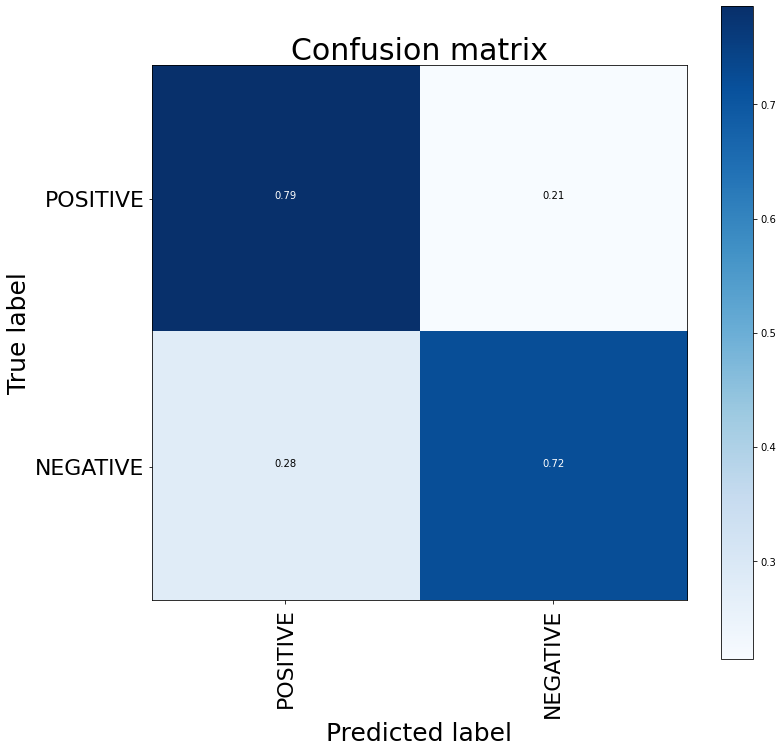

<class 'numpy.ndarray'>
['NEGATIVE' 'NEGATIVE' 'NEGATIVE' 'POSITIVE' 'POSITIVE']
1580782    POSITIVE
1528609    POSITIVE
4930       NEGATIVE
69474      NEGATIVE
15105      NEGATIVE
Name: target, dtype: object
Accuracy score: 0.7543316831683168
Precision score: 0.7714751340553044
Recall score: 0.7245840122450995
F1 score: 0.7472947167409293
              precision    recall  f1-score   support

    NEGATIVE       0.74      0.78      0.76     20147
    POSITIVE       0.77      0.72      0.75     20253

    accuracy                           0.75     40400
   macro avg       0.76      0.75      0.75     40400
weighted avg       0.76      0.75      0.75     40400



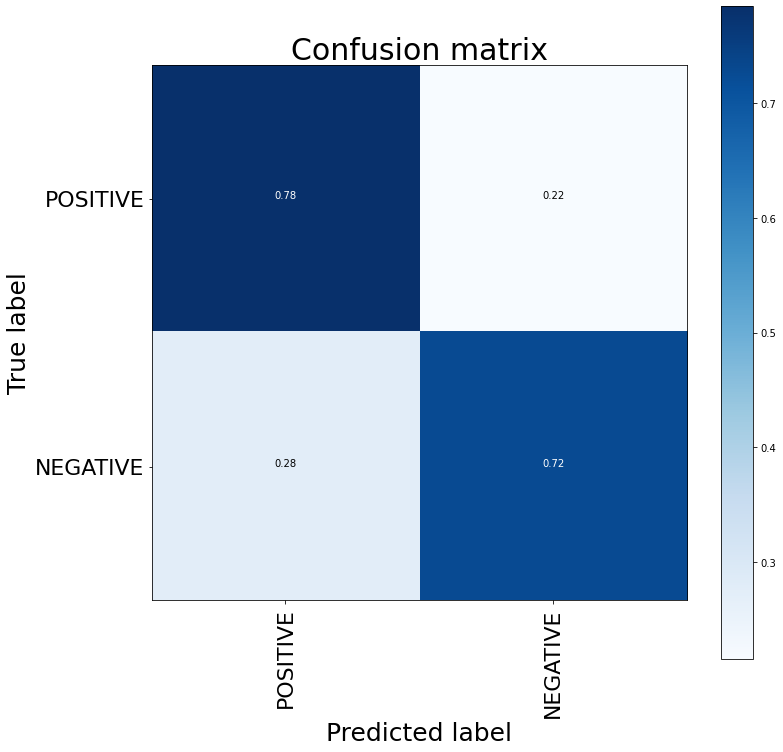

In [70]:
df_200_train, df_200_test = train_test_split(df_200_1p_salt_stem_lem, test_size=1-TRAIN_SIZE)
print("TRAIN size 200K tweets with 1% wrong sentiment labels:", len(df_200_train))
print("TEST size 200K tweets with 1% wrong sentiment labels:", len(df_200_test))

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Instantiate the CountVectorizer method
count_vector = CountVectorizer()

# Fit the training data and then return the matrix
training_200_data = count_vector.fit_transform(df_200_train.stem_text)

# Transform testing data and return the matrix. 
testing_200_data = count_vector.transform(df_200_test.stem_text)

naive_bayes = MultinomialNB()
naive_bayes.fit(training_200_data,df_200_train.target)

#Make prediction on test dataset
predictions = naive_bayes.predict(testing_200_data)

print(type(predictions))

print(predictions[:5])

print(df_200_test.target[:5])

# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: {}'.format(accuracy_score(df_200_test.target, predictions)))
print('Precision score: {}'.format(precision_score(df_200_test.target, predictions, pos_label="POSITIVE")))
print('Recall score: {}'.format(recall_score(df_200_test.target, predictions, pos_label="POSITIVE")))
print('F1 score: {}'.format(f1_score(df_200_test.target, predictions, pos_label="POSITIVE")))

print(classification_report(df_200_test.target, predictions))


cnf_matrix = confusion_matrix(df_200_test.target, predictions)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_200_train.target.unique(), title="Confusion matrix")
plt.show()

# Instantiate the CountVectorizer method
count_vector = CountVectorizer()

# Fit the training data and then return the matrix
training_200_data = count_vector.fit_transform(df_200_train.lemma_text)

# Transform testing data and return the matrix. 
testing_200_data = count_vector.transform(df_200_test.lemma_text)

naive_bayes = MultinomialNB()
naive_bayes.fit(training_200_data,df_200_train.target)

#Make prediction on test dataset
predictions = naive_bayes.predict(testing_200_data)

print(type(predictions))

print(predictions[:5])

print(df_200_test.target[:5])

# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: {}'.format(accuracy_score(df_200_test.target, predictions)))
print('Precision score: {}'.format(precision_score(df_200_test.target, predictions, pos_label="POSITIVE")))
print('Recall score: {}'.format(recall_score(df_200_test.target, predictions, pos_label="POSITIVE")))
print('F1 score: {}'.format(f1_score(df_200_test.target, predictions, pos_label="POSITIVE")))

print(classification_report(df_200_test.target, predictions))


cnf_matrix = confusion_matrix(df_200_test.target, predictions)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_200_train.target.unique(), title="Confusion matrix")
plt.show()

TRAIN size 200K tweets with 3% wrong sentiment labels: 164800
TEST size 200K tweets with 3% wrong sentiment labels: 41200
<class 'numpy.ndarray'>
['NEGATIVE' 'POSITIVE' 'NEGATIVE' 'NEGATIVE' 'NEGATIVE']
61427      NEGATIVE
1584803    POSITIVE
50320      NEGATIVE
1572089    POSITIVE
84582      NEGATIVE
Name: target, dtype: object
Accuracy score: 0.7464805825242719
Precision score: 0.7584693877551021
Recall score: 0.7224571123098605
F1 score: 0.7400253876596063
              precision    recall  f1-score   support

    NEGATIVE       0.74      0.77      0.75     20623
    POSITIVE       0.76      0.72      0.74     20577

    accuracy                           0.75     41200
   macro avg       0.75      0.75      0.75     41200
weighted avg       0.75      0.75      0.75     41200



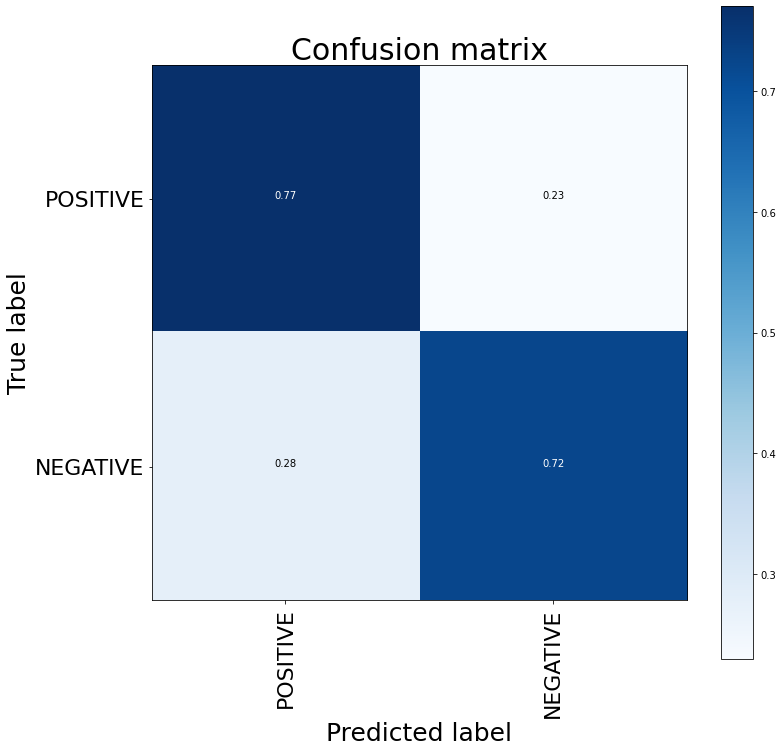

<class 'numpy.ndarray'>
['NEGATIVE' 'POSITIVE' 'NEGATIVE' 'NEGATIVE' 'NEGATIVE']
61427      NEGATIVE
1584803    POSITIVE
50320      NEGATIVE
1572089    POSITIVE
84582      NEGATIVE
Name: target, dtype: object
Accuracy score: 0.7462621359223301
Precision score: 0.7543083957192384
Recall score: 0.7296010108373426
F1 score: 0.7417490118577075
              precision    recall  f1-score   support

    NEGATIVE       0.74      0.76      0.75     20623
    POSITIVE       0.75      0.73      0.74     20577

    accuracy                           0.75     41200
   macro avg       0.75      0.75      0.75     41200
weighted avg       0.75      0.75      0.75     41200



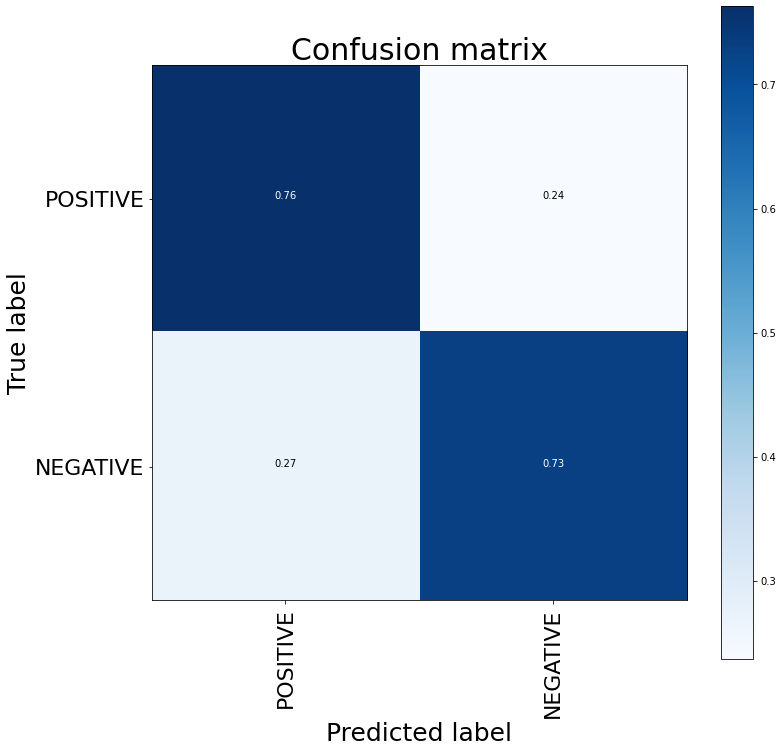

In [75]:
df_200_train, df_200_test = train_test_split(df_200_3p_salt_stem_lem, test_size=1-TRAIN_SIZE)
print("TRAIN size 200K tweets with 3% wrong sentiment labels:", len(df_200_train))
print("TEST size 200K tweets with 3% wrong sentiment labels:", len(df_200_test))

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Instantiate the CountVectorizer method
count_vector = CountVectorizer()

# Fit the training data and then return the matrix
training_200_data = count_vector.fit_transform(df_200_train.stem_text)

# Transform testing data and return the matrix. 
testing_200_data = count_vector.transform(df_200_test.stem_text)

naive_bayes = MultinomialNB()
naive_bayes.fit(training_200_data,df_200_train.target)

#Make prediction on test dataset
predictions = naive_bayes.predict(testing_200_data)

print(type(predictions))

print(predictions[:5])

print(df_200_test.target[:5])

# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: {}'.format(accuracy_score(df_200_test.target, predictions)))
print('Precision score: {}'.format(precision_score(df_200_test.target, predictions, pos_label="POSITIVE")))
print('Recall score: {}'.format(recall_score(df_200_test.target, predictions, pos_label="POSITIVE")))
print('F1 score: {}'.format(f1_score(df_200_test.target, predictions, pos_label="POSITIVE")))

print(classification_report(df_200_test.target, predictions))


cnf_matrix = confusion_matrix(df_200_test.target, predictions)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_200_train.target.unique(), title="Confusion matrix")
plt.show()

# Instantiate the CountVectorizer method
count_vector = CountVectorizer()

# Fit the training data and then return the matrix
training_200_data = count_vector.fit_transform(df_200_train.lemma_text)

# Transform testing data and return the matrix. 
testing_200_data = count_vector.transform(df_200_test.lemma_text)

naive_bayes = MultinomialNB()
naive_bayes.fit(training_200_data,df_200_train.target)

#Make prediction on test dataset
predictions = naive_bayes.predict(testing_200_data)

print(type(predictions))

print(predictions[:5])

print(df_200_test.target[:5])

# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: {}'.format(accuracy_score(df_200_test.target, predictions)))
print('Precision score: {}'.format(precision_score(df_200_test.target, predictions, pos_label="POSITIVE")))
print('Recall score: {}'.format(recall_score(df_200_test.target, predictions, pos_label="POSITIVE")))
print('F1 score: {}'.format(f1_score(df_200_test.target, predictions, pos_label="POSITIVE")))

print(classification_report(df_200_test.target, predictions))


cnf_matrix = confusion_matrix(df_200_test.target, predictions)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_200_train.target.unique(), title="Confusion matrix")
plt.show()

TRAIN size 200K tweets with 5% wrong sentiment labels: 168000
TEST size 200K tweets with 5% wrong sentiment labels: 42000
<class 'numpy.ndarray'>
['POSITIVE' 'NEGATIVE' 'NEGATIVE' 'POSITIVE' 'POSITIVE']
1570465    POSITIVE
23861      NEGATIVE
44399      NEGATIVE
1562739    POSITIVE
1580289    POSITIVE
Name: target, dtype: object
Accuracy score: 0.7318095238095238
Precision score: 0.7438692098092643
Recall score: 0.7043478260869566
F1 score: 0.7235692549327575
              precision    recall  f1-score   support

    NEGATIVE       0.72      0.76      0.74     21070
    POSITIVE       0.74      0.70      0.72     20930

    accuracy                           0.73     42000
   macro avg       0.73      0.73      0.73     42000
weighted avg       0.73      0.73      0.73     42000



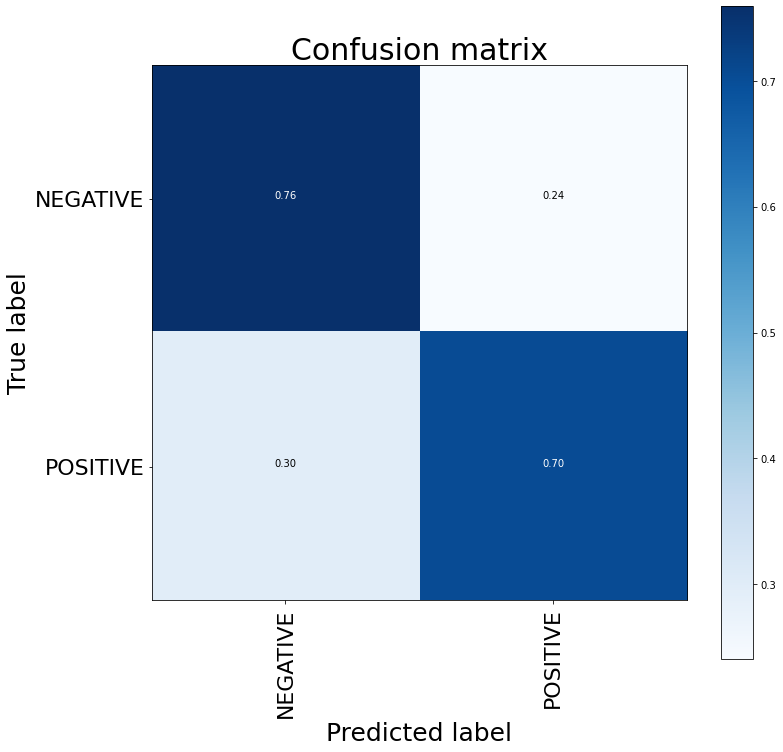

<class 'numpy.ndarray'>
['POSITIVE' 'NEGATIVE' 'POSITIVE' 'POSITIVE' 'POSITIVE']
1570465    POSITIVE
23861      NEGATIVE
44399      NEGATIVE
1562739    POSITIVE
1580289    POSITIVE
Name: target, dtype: object
Accuracy score: 0.730904761904762
Precision score: 0.7388370708473904
Recall score: 0.7115145723841376
F1 score: 0.7249184637102664
              precision    recall  f1-score   support

    NEGATIVE       0.72      0.75      0.74     21070
    POSITIVE       0.74      0.71      0.72     20930

    accuracy                           0.73     42000
   macro avg       0.73      0.73      0.73     42000
weighted avg       0.73      0.73      0.73     42000



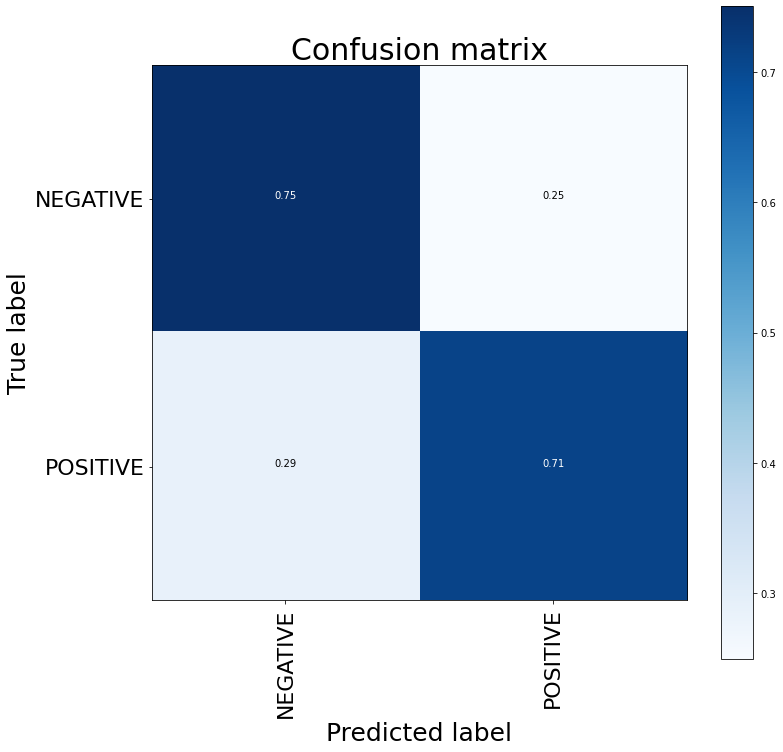

In [76]:
df_200_train, df_200_test = train_test_split(df_200_5p_salt_stem_lem, test_size=1-TRAIN_SIZE)
print("TRAIN size 200K tweets with 5% wrong sentiment labels:", len(df_200_train))
print("TEST size 200K tweets with 5% wrong sentiment labels:", len(df_200_test))

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Instantiate the CountVectorizer method
count_vector = CountVectorizer()

# Fit the training data and then return the matrix
training_200_data = count_vector.fit_transform(df_200_train.stem_text)

# Transform testing data and return the matrix. 
testing_200_data = count_vector.transform(df_200_test.stem_text)

naive_bayes = MultinomialNB()
naive_bayes.fit(training_200_data,df_200_train.target)

#Make prediction on test dataset
predictions = naive_bayes.predict(testing_200_data)

print(type(predictions))

print(predictions[:5])

print(df_200_test.target[:5])

# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: {}'.format(accuracy_score(df_200_test.target, predictions)))
print('Precision score: {}'.format(precision_score(df_200_test.target, predictions, pos_label="POSITIVE")))
print('Recall score: {}'.format(recall_score(df_200_test.target, predictions, pos_label="POSITIVE")))
print('F1 score: {}'.format(f1_score(df_200_test.target, predictions, pos_label="POSITIVE")))

print(classification_report(df_200_test.target, predictions))


cnf_matrix = confusion_matrix(df_200_test.target, predictions)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_200_train.target.unique(), title="Confusion matrix")
plt.show()

# Instantiate the CountVectorizer method
count_vector = CountVectorizer()

# Fit the training data and then return the matrix
training_200_data = count_vector.fit_transform(df_200_train.lemma_text)

# Transform testing data and return the matrix. 
testing_200_data = count_vector.transform(df_200_test.lemma_text)

naive_bayes = MultinomialNB()
naive_bayes.fit(training_200_data,df_200_train.target)

#Make prediction on test dataset
predictions = naive_bayes.predict(testing_200_data)

print(type(predictions))

print(predictions[:5])

print(df_200_test.target[:5])

# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: {}'.format(accuracy_score(df_200_test.target, predictions)))
print('Precision score: {}'.format(precision_score(df_200_test.target, predictions, pos_label="POSITIVE")))
print('Recall score: {}'.format(recall_score(df_200_test.target, predictions, pos_label="POSITIVE")))
print('F1 score: {}'.format(f1_score(df_200_test.target, predictions, pos_label="POSITIVE")))

print(classification_report(df_200_test.target, predictions))


cnf_matrix = confusion_matrix(df_200_test.target, predictions)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_200_train.target.unique(), title="Confusion matrix")
plt.show()

In [73]:
!apt-get -qq install texlive texlive-xetex texlive-latex-extra pandoc 
!pip install --quiet pypandoc

Extracting templates from packages: 100%
Preconfiguring packages ...
Selecting previously unselected package fonts-droid-fallback.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../00-fonts-droid-fallback_1%3a6.0.1r16-1.1_all.deb ...
Unpacking fonts-droid-fallback (1:6.0.1r16-1.1) ...
Selecting previously unselected package fonts-lato.
Preparing to unpack .../01-fonts-lato_2.0-2_all.deb ...
Unpacking fonts-lato (2.0-2) ...
Selecting previously unselected package poppler-data.
Preparing to unpack .../02-poppler-data_0.4.8-2_all.deb ...
Unpacking poppler-data (0.4.8-2) ...
Selecting previously unselected package tex-common.
Preparing to unpack .../03-tex-common_6.09_all.deb ...
Unpacking tex-common (6.09) ...
Selecting previously unselected package fonts-lmodern.
Preparing to unpack .../04-fonts-lmodern_2.004.5-3_all.deb ...
Unpacking fonts-lmodern (2.004.5-3) ...
Selecting previously unselected package fonts-noto-mono.
Preparing to unpack .

In [74]:
!jupyter nbconvert --to PDF "/content/drive/MyDrive/Masters/VTech Subjects/CS 5824 Advanced Machine Learning/term paper/code/Sentiment_Analysis_Naive_Bayes.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Masters/VTech Subjects/CS 5824 Advanced Machine Learning/term paper/code/Sentiment_Analysis_Naive_Bayes.ipynb to PDF
[NbConvertApp] Support files will be in Sentiment_Analysis_Naive_Bayes_files/
[NbConvertApp] Making directory ./Sentiment_Analysis_Naive_Bayes_files
[NbConvertApp] Making directory ./Sentiment_Analysis_Naive_Bayes_files
[NbConvertApp] Making directory ./Sentiment_Analysis_Naive_Bayes_files
[NbConvertApp] Making directory ./Sentiment_Analysis_Naive_Bayes_files
[NbConvertApp] Making directory ./Sentiment_Analysis_Naive_Bayes_files
[NbConvertApp] Making directory ./Sentiment_Analysis_Naive_Bayes_files
[NbConvertApp] Making directory ./Sentiment_Analysis_Naive_Bayes_files
[NbConvertApp] Making directory ./Sentiment_Analysis_Naive_Bayes_files
[NbConvertApp] Making directory ./Sentiment_Analysis_Naive_Bayes_files
[NbConvertApp] Making directory ./Sentiment_Analysis_Naive_Bayes_files
[NbConvertApp] Making directory ./Sen